# Multiclass Supervised Geological Mapping

In [1]:
# User defined inputs
xRes = 50
yRes = 50
crs = 'epsg:26909'
cube_path = './2_cubes/Hypercube_06-02-2022_1639_PCA.csv'
output_path = './3_processing/3_tuning_model_outputs/'
correspondance_dict_path = './2_cubes/Geology_CategoryCodes_wDrilling.csv'



In [ ]:
#TODOs
#compare_models: can the aesthetics of this be improved? And technically I think it is 'validation' not 'testing' in that instance
#In savefig(), need to set facecolor='white' for all figures; the transparent background can be problematic for some viewers
#plot_shap_values: doesn't seem to output any figures?
#multiclass_confusion_matrix_plot: only outputs one figure, may need to add an input to be 'filename' so they don't overwrite each other


## Basic imports

In [2]:
import glob

import numpy as np
import pandas as pd
import os

import GeoDS

from GeoDS import hypercube
from GeoDS import utilities
from GeoDS.supervised import mapclass
from GeoDS import reporting 
from GeoDS.prospectivity import featureimportance, hyperparameterstuning
from GeoDS import eda

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.stats import randint as sp_randint
import scipy

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
import lightgbm
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import lightgbm
import xgboost
from sklearn.neural_network import MLPClassifier

import mlflow
import importlib
from joblib import dump, load
pd.set_option('display.max_columns', None)
rand = 42

## MLFlow integration

Lets define variables that are user defined and that will be reused all along the workflow.

In [3]:


mlflow.set_tracking_uri('http://mlflow.litholens.com:8080/')
exp_id = mlflow.set_experiment("GeoDS suite")

# mlflow.end_run()
mlflow.start_run()
mlflow.log_param("GeoDS Version", GeoDS.__version__)
mlflow.log_param("crs",crs)
mlflow.log_param("res",(xRes,yRes))




# Important Preprocessing Note: 
- For multiclass classification xgboost expects your labels to start with [0,1...n-1] so make sure to check your labels 
- if they are not in this range and they start with [1,2..n]
- simply apply df.substract operation on y after calling hypercube.getrowwithlabels and you should be good to go. eg `y = y-1`

Lets also prepare to turn back integers categorical columns back into their original string

In [3]:
# needs User validation
correspondance = pd.read_csv(correspondance_dict_path)
correspondance_dict = dict(zip(correspondance['Code'], correspondance['Rock type']))

#mlflow.active_run()
#mlflow.log_dict(correspondance_dict, "correspondance.json")

In [4]:
correspondance_dict

{1: 'felsic_intrusives_high_k_flows',
 2: 'mafic_sub-porphyritic',
 3: 'mafic-intermed_volc-intrus',
 4: 'Quock_BLG',
 5: 'silicious_calcic_sed_rx'}

You also need to define your columns, which is your training layer and load them accordingly using Hypercube methods.

In [5]:
# user defined for now..there are updates that remove this step but still this will be necessary to remove few layers from the workflow
PCs = ['PC_mag_long_1',
       'PC_mag_long_2',
       'PC_mag_long_3',
       'PC_mag_short_1',
       'PC_mag_short_2',
       'PC_mag_short_3',
       'PC_SA_PseudoGrav_HGM_1',
       'PC_SA_RTP_ContrastEnh_1',
       'PC_texture_1',
       'PC_texture_2',
       #'PC_texture_3',
       #'PC_texture_4',
       #'PC_grs_1', 'PC_grs_2', 'PC_grs_3', 'PC_grs_4',
       'Pretium_RTP_contrastEnh' 
      ]


targets= ['lithogeochem_targets',
          'lithogeochem_targets_buffered',
          'lithogeochem_targets_wDrilling',
          'lithogeochem_targets_wDrilling_buffered'
         ]

my_target = 'lithogeochem_targets_wDrilling'

coords = ['x', 'y']

columns = {
    'PCs' : PCs,
    'coordinates' : coords,
    'targets': targets
}
#mlflow.active_run()
#mlflow.log_dict(columns, "columns.json")

In [6]:

cube = hypercube.HyperCube(input_data=cube_path,
                           x_field='x', y_field='y', crs=crs, columns_dict=columns)
# The -9999s are not being recognized as 'NaN' - so we force that here
cube.df.replace(-9999.0, np.nan, inplace = True)
#use the dropna methods to drop nans along a particular subset
cube.dropna(subset='PCs')
#Filtering out snow values for radiometrics
cube.summary()

numeric_cols = columns['PCs']


Using pandas to read the csv file!
<class 'pandas.core.frame.DataFrame'>
Int64Index: 342825 entries, 1946 to 362343
Data columns (total 17 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   x                                        342825 non-null  float64
 1   y                                        342825 non-null  float64
 2   PC_mag_long_1                            342825 non-null  float64
 3   PC_mag_long_2                            342825 non-null  float64
 4   PC_mag_long_3                            342825 non-null  float64
 5   PC_mag_short_1                           342825 non-null  float64
 6   PC_mag_short_2                           342825 non-null  float64
 7   PC_mag_short_3                           342825 non-null  float64
 8   PC_SA_PseudoGrav_HGM_1                   342825 non-null  float64
 9   PC_SA_RTP_ContrastEnh_1                  342825 non-null  float64

Run this cell to calculate how many training labels you have

In [7]:

lithos = cube.df.replace(to_replace={my_target: correspondance_dict})
lithos[my_target].value_counts()

mafic-intermed_volc-intrus        2829
felsic_intrusives_high_k_flows    1371
Quock_BLG                         1306
mafic_sub-porphyritic              793
silicious_calcic_sed_rx            343
Name: lithogeochem_targets_wDrilling, dtype: int64

In [8]:
cube.df[my_target].value_counts()

3.0    2829
1.0    1371
4.0    1306
2.0     793
5.0     343
Name: lithogeochem_targets_wDrilling, dtype: int64

## 2 - Pre-pipeline Numerical Pre-Processing (Preliminary PCA)


(1) get the X and y with labels and split them into training and testing sets, get also the whole observation dataset.

In [9]:
from sklearn.model_selection import cross_val_score, train_test_split

X, y = cube.getRowsWithLabelOnly(subsets=['PCs'], target=my_target)
# Matching the range of targets to work with XGBoost
y = y-1

X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, train_size=0.75,
        random_state = rand)

all_X = cube.subset(['PCs'])

In [10]:
# checking the counts for each class in targets
y_train.value_counts(), y_test.value_counts()

(2    2122
 0    1028
 3     979
 1     595
 4     257
 Name: lithogeochem_targets_wDrilling, dtype: int64,
 2    707
 0    343
 3    327
 1    198
 4     86
 Name: lithogeochem_targets_wDrilling, dtype: int64)

# Main changes
- Model tuning
- Logging artifacts
- Model reporting

# Model Tuning

In [11]:
from sklearn.model_selection import StratifiedKFold
from importlib import reload
#reload(hyperparameterstuning)

# Defining CV
cv = StratifiedKFold(n_splits=5)
models = ['CatBoost', 'RandomForest', 'LGBM', 'XGBoost']

categorical_features_indices = None
groups = None

hyperparameterstuning.Optimizer(30, models, output_path, numeric_cols, categorical_features_indices, X_train, y_train, cv, groups,
              scoring=['f1_macro','precision_macro', 'recall_macro'],
              random_state=rand, smart_map = True)

# mlflow call
#mlflow.active_run()
#mlflow.log_dict({"models":models}, "models.json")

[I 2022-09-15 18:02:13,607] A new study created in memory with name: CatBoost_study


{'random_state': 42, 'iterations': 531, 'depth': 10, 'random_strength': 73, 'bagging_temperature': 2.481040974867813, 'od_type': 'IncToDec', 'od_wait': 12}


[I 2022-09-15 18:06:26,026] Trial 0 finished with value: 0.7825409335717273 and parameters: {'iterations': 531, 'depth': 10, 'random_strength': 73, 'bagging_temperature': 2.481040974867813, 'od_type': 'IncToDec', 'od_wait': 12}. Best is trial 0 with value: 0.7825409335717273.


{'fit_time': array([249.28572679, 231.21888566, 249.29611254, 249.43322682,
       231.66742778]), 'score_time': array([0.01412916, 0.05501866, 0.01876283, 0.01201057, 0.06022406]), 'test_f1_macro': array([0.76146872, 0.77379119, 0.79303671, 0.79317058, 0.79123746]), 'train_f1_macro': array([0.91361866, 0.91054213, 0.91498062, 0.90745859, 0.91669864]), 'test_precision_macro': array([0.73922371, 0.75487688, 0.77898681, 0.77792338, 0.76732053]), 'train_precision_macro': array([0.88999046, 0.88643317, 0.89403189, 0.88334383, 0.89386473]), 'test_recall_macro': array([0.79634078, 0.802522  , 0.81670101, 0.83135605, 0.82863824]), 'train_recall_macro': array([0.9458651 , 0.94364736, 0.94365948, 0.94385683, 0.94727619])}
{'random_state': 42, 'iterations': 900, 'depth': 8, 'random_strength': 71, 'bagging_temperature': 0.012087541473056965, 'od_type': 'IncToDec', 'od_wait': 18}


[I 2022-09-15 18:08:15,744] Trial 1 finished with value: 0.7835023785377941 and parameters: {'iterations': 900, 'depth': 8, 'random_strength': 71, 'bagging_temperature': 0.012087541473056965, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 1 with value: 0.7835023785377941.


{'fit_time': array([ 96.23169971, 107.08111572,  96.23967743, 107.25173712,
       107.27574253]), 'score_time': array([0.06309843, 0.03130364, 0.06412411, 0.01400495, 0.01299429]), 'test_f1_macro': array([0.7473885 , 0.78094205, 0.81162188, 0.79620178, 0.78135769]), 'train_f1_macro': array([0.91648928, 0.91105066, 0.91444318, 0.9048843 , 0.91713598]), 'test_precision_macro': array([0.72903308, 0.76296779, 0.7957619 , 0.77743731, 0.7567567 ]), 'train_precision_macro': array([0.89307627, 0.88724675, 0.89335421, 0.88067092, 0.89400381]), 'test_recall_macro': array([0.77756158, 0.80691082, 0.83698212, 0.8347677 , 0.8204366 ]), 'train_recall_macro': array([0.94844848, 0.9438392 , 0.94337696, 0.94096316, 0.94736949])}
{'random_state': 42, 'iterations': 386, 'depth': 5, 'random_strength': 30, 'bagging_temperature': 1.256104370001356, 'od_type': 'IncToDec', 'od_wait': 35}


[I 2022-09-15 18:08:21,512] Trial 2 pruned. 


{'fit_time': array([5.14642024, 5.20740438, 5.56574726, 5.60164642, 5.60455394]), 'score_time': array([0.02221274, 0.02100968, 0.01699638, 0.00892282, 0.0079937 ]), 'test_f1_macro': array([0.72302027, 0.72774707, 0.76243312, 0.74820577, 0.72677745]), 'train_f1_macro': array([0.87642302, 0.87348121, 0.86745936, 0.85312699, 0.8680392 ]), 'test_precision_macro': array([0.70318299, 0.70654968, 0.74305913, 0.72548214, 0.70263058]), 'train_precision_macro': array([0.85170128, 0.84651869, 0.84110877, 0.82432645, 0.8412275 ]), 'test_recall_macro': array([0.75945269, 0.77096921, 0.80291288, 0.79317739, 0.77788102]), 'train_recall_macro': array([0.9133571 , 0.91465811, 0.90768837, 0.90107564, 0.90894086])}
{'random_state': 42, 'iterations': 354, 'depth': 6, 'random_strength': 37, 'bagging_temperature': 0.6672367170464207, 'od_type': 'IncToDec', 'od_wait': 31}


[I 2022-09-15 18:08:31,523] Trial 3 pruned. 


{'fit_time': array([9.21086907, 9.20686603, 9.9663105 , 9.95331454, 9.95629811]), 'score_time': array([0.03701377, 0.03400207, 0.00900316, 0.00999045, 0.00999784]), 'test_f1_macro': array([0.7390531 , 0.75499994, 0.76936077, 0.77422255, 0.76076374]), 'train_f1_macro': array([0.89931729, 0.8950294 , 0.89775745, 0.88597739, 0.89522993]), 'test_precision_macro': array([0.71777974, 0.7355755 , 0.75323001, 0.75593135, 0.7345395 ]), 'train_precision_macro': array([0.87474376, 0.86856395, 0.87428879, 0.85986125, 0.86966013]), 'test_recall_macro': array([0.77502615, 0.78893201, 0.79969718, 0.80994185, 0.80787275]), 'train_recall_macro': array([0.93422836, 0.93386612, 0.93030138, 0.92687824, 0.9316716 ])}
{'random_state': 42, 'iterations': 694, 'depth': 4, 'random_strength': 61, 'bagging_temperature': 0.04809461967501574, 'od_type': 'Iter', 'od_wait': 49}


[I 2022-09-15 18:08:39,234] Trial 4 pruned. 


{'fit_time': array([5.33666635, 5.33367157, 4.92636418, 4.97637749, 5.31665444]), 'score_time': array([0.01099825, 0.01098943, 0.02599859, 0.02098751, 0.01200294]), 'test_f1_macro': array([0.72524799, 0.70413609, 0.74688568, 0.74234436, 0.73371793]), 'train_f1_macro': array([0.8541333 , 0.85170243, 0.84560963, 0.83686535, 0.84877176]), 'test_precision_macro': array([0.70364905, 0.68366529, 0.72678959, 0.7204827 , 0.70609448]), 'train_precision_macro': array([0.82923236, 0.82282586, 0.81829119, 0.80733382, 0.82069958]), 'test_recall_macro': array([0.76508401, 0.74605127, 0.79300887, 0.78929193, 0.78864089]), 'train_recall_macro': array([0.89482073, 0.90113107, 0.8898599 , 0.88854129, 0.89441973])}
{'random_state': 42, 'iterations': 857, 'depth': 6, 'random_strength': 9, 'bagging_temperature': 5.456725485601478, 'od_type': 'IncToDec', 'od_wait': 30}


[I 2022-09-15 18:09:04,670] Trial 5 pruned. 


{'fit_time': array([16.77377796, 21.74096775, 21.72795367, 22.5940845 , 22.62754512]), 'score_time': array([0.00898981, 0.02702355, 0.02601266, 0.02044916, 0.02100372]), 'test_f1_macro': array([0.734636  , 0.74220162, 0.78368002, 0.76358789, 0.74624038]), 'train_f1_macro': array([0.89129126, 0.88677669, 0.88584134, 0.87797624, 0.88595025]), 'test_precision_macro': array([0.71384167, 0.72331219, 0.76458806, 0.74264157, 0.72174525]), 'train_precision_macro': array([0.86543265, 0.85960041, 0.86057178, 0.84907733, 0.85941276]), 'test_recall_macro': array([0.77439879, 0.77433614, 0.81604919, 0.81101262, 0.78882974]), 'train_recall_macro': array([0.93071897, 0.92769842, 0.92303529, 0.92415735, 0.92429589])}
{'random_state': 42, 'iterations': 275, 'depth': 10, 'random_strength': 26, 'bagging_temperature': 4.467752817973908, 'od_type': 'Iter', 'od_wait': 32}


[I 2022-09-15 18:11:14,842] Trial 6 finished with value: 0.7761128794512688 and parameters: {'iterations': 275, 'depth': 10, 'random_strength': 26, 'bagging_temperature': 4.467752817973908, 'od_type': 'Iter', 'od_wait': 32}. Best is trial 1 with value: 0.7835023785377941.


{'fit_time': array([129.88033295, 130.1214931 , 129.96734428, 120.71459937,
       120.79859161]), 'score_time': array([0.02602744, 0.0130074 , 0.02798915, 0.05999565, 0.03868055]), 'test_f1_macro': array([0.75460418, 0.77183279, 0.78419543, 0.78819607, 0.78173593]), 'train_f1_macro': array([0.90892908, 0.90236743, 0.91544959, 0.90502067, 0.91402072]), 'test_precision_macro': array([0.7344736 , 0.75820904, 0.77434515, 0.76922902, 0.75926542]), 'train_precision_macro': array([0.88383864, 0.87669587, 0.89507656, 0.88130994, 0.88949791]), 'test_recall_macro': array([0.78432332, 0.79156462, 0.80312208, 0.82572328, 0.81764884]), 'train_recall_macro': array([0.94449089, 0.94027482, 0.94249289, 0.94110174, 0.94690537])}
{'random_state': 42, 'iterations': 388, 'depth': 10, 'random_strength': 78, 'bagging_temperature': 57.27904470799624, 'od_type': 'IncToDec', 'od_wait': 47}


[I 2022-09-15 18:11:15,912] Trial 7 pruned. 


{'fit_time': array([1.01834798, 1.01536965, 1.00837994, 1.00537872, 1.00937867]), 'score_time': array([0.01300001, 0.01199508, 0.01200199, 0.01199508, 0.01199818]), 'test_f1_macro': array([0.01982841, 0.01948424, 0.01948424, 0.01948424, 0.04269058]), 'train_f1_macro': array([0.01957508, 0.01966118, 0.01966118, 0.01966118, 0.04268101]), 'test_precision_macro': array([0.01043129, 0.01024096, 0.01024096, 0.01024096, 0.02389558]), 'train_precision_macro': array([0.01029116, 0.01033877, 0.01033877, 0.01033877, 0.02388959]), 'test_recall_macro': array([0.2, 0.2, 0.2, 0.2, 0.2]), 'train_recall_macro': array([0.2, 0.2, 0.2, 0.2, 0.2])}
{'random_state': 42, 'iterations': 316, 'depth': 5, 'random_strength': 4, 'bagging_temperature': 0.20013420622879985, 'od_type': 'IncToDec', 'od_wait': 43}


[I 2022-09-15 18:11:20,333] Trial 8 pruned. 


{'fit_time': array([4.3714478 , 4.36796689, 4.38096237, 3.98429966, 3.98231053]), 'score_time': array([0.00752497, 0.00801468, 0.00799489, 0.02499986, 0.02201438]), 'test_f1_macro': array([0.74341365, 0.73188079, 0.78490716, 0.75774729, 0.73579266]), 'train_f1_macro': array([0.88581297, 0.88470723, 0.87069628, 0.8645406 , 0.87572135]), 'test_precision_macro': array([0.72198557, 0.7110845 , 0.76306376, 0.73985699, 0.70855135]), 'train_precision_macro': array([0.86133102, 0.8578788 , 0.8424146 , 0.83775945, 0.85017024]), 'test_recall_macro': array([0.78258702, 0.7678581 , 0.82487722, 0.8027541 , 0.78860775]), 'train_recall_macro': array([0.92237822, 0.92513615, 0.91380893, 0.90782695, 0.91473915])}
{'random_state': 42, 'iterations': 517, 'depth': 5, 'random_strength': 54, 'bagging_temperature': 0.0366181922039243, 'od_type': 'IncToDec', 'od_wait': 50}


[I 2022-09-15 18:11:27,592] Trial 9 pruned. 


{'fit_time': array([7.22283316, 6.63052559, 6.57930136, 7.19480205, 7.15181923]), 'score_time': array([0.00899363, 0.01799846, 0.02099466, 0.00899959, 0.01498342]), 'test_f1_macro': array([0.73480568, 0.723656  , 0.76878827, 0.75789294, 0.74146586]), 'train_f1_macro': array([0.8858294 , 0.8850895 , 0.88164378, 0.86953582, 0.87584679]), 'test_precision_macro': array([0.71511059, 0.7025682 , 0.74936646, 0.73649598, 0.71590632]), 'train_precision_macro': array([0.86213487, 0.85874158, 0.85492154, 0.84208161, 0.84949705]), 'test_recall_macro': array([0.76831333, 0.7631267 , 0.80772734, 0.80112703, 0.78912213]), 'train_recall_macro': array([0.92034619, 0.92445754, 0.92038605, 0.91415685, 0.91517091])}
{'random_state': 42, 'iterations': 985, 'depth': 8, 'random_strength': 97, 'bagging_temperature': 0.011799062523159294, 'od_type': 'Iter', 'od_wait': 12}


[I 2022-09-15 18:13:24,338] Trial 10 finished with value: 0.785031333742646 and parameters: {'iterations': 985, 'depth': 8, 'random_strength': 97, 'bagging_temperature': 0.011799062523159294, 'od_type': 'Iter', 'od_wait': 12}. Best is trial 10 with value: 0.785031333742646.


{'fit_time': array([116.6279273 , 116.64692998, 107.38712478, 116.67071462,
       107.0255115 ]), 'score_time': array([0.01199841, 0.01299191, 0.04001403, 0.01229119, 0.06259489]), 'test_f1_macro': array([0.75846059, 0.7784522 , 0.81290624, 0.79609481, 0.77924283]), 'train_f1_macro': array([0.9182941 , 0.91495343, 0.91653822, 0.90522392, 0.9164904 ]), 'test_precision_macro': array([0.73962769, 0.76084299, 0.79722795, 0.7786741 , 0.75476202]), 'train_precision_macro': array([0.89612769, 0.89207328, 0.89482813, 0.88087747, 0.89243988]), 'test_recall_macro': array([0.78869225, 0.8038611 , 0.83910542, 0.83585862, 0.81732662]), 'train_recall_macro': array([0.94875811, 0.94596392, 0.94556812, 0.94110818, 0.94863655])}
{'random_state': 42, 'iterations': 991, 'depth': 8, 'random_strength': 96, 'bagging_temperature': 0.010353204153309653, 'od_type': 'Iter', 'od_wait': 12}


[I 2022-09-15 18:15:30,858] Trial 11 finished with value: 0.7874134194906773 and parameters: {'iterations': 991, 'depth': 8, 'random_strength': 96, 'bagging_temperature': 0.010353204153309653, 'od_type': 'Iter', 'od_wait': 12}. Best is trial 11 with value: 0.7874134194906773.


{'fit_time': array([125.9875648 , 109.16479659, 109.63402414, 125.9755671 ,
       126.44278455]), 'score_time': array([0.02500343, 0.1809938 , 0.14936328, 0.03400493, 0.01200151]), 'test_f1_macro': array([0.76740966, 0.77973078, 0.81191885, 0.79866369, 0.77934411]), 'train_f1_macro': array([0.91922349, 0.91287484, 0.91705152, 0.90572566, 0.9129188 ]), 'test_precision_macro': array([0.74846543, 0.76202635, 0.79773354, 0.78158001, 0.75549625]), 'train_precision_macro': array([0.89716464, 0.88952468, 0.89592794, 0.88193009, 0.88863694]), 'test_recall_macro': array([0.79729722, 0.80565932, 0.83505189, 0.83879581, 0.81670602]), 'train_recall_macro': array([0.9491552 , 0.94454239, 0.945556  , 0.9420319 , 0.94550837])}
{'random_state': 42, 'iterations': 981, 'depth': 8, 'random_strength': 100, 'bagging_temperature': 0.011028928813293946, 'od_type': 'Iter', 'od_wait': 10}


[I 2022-09-15 18:17:30,290] Trial 12 pruned. 


{'fit_time': array([119.29174662, 119.26773214, 119.36531973, 106.61173677,
       106.75097132]), 'score_time': array([0.01757717, 0.01499343, 0.00900054, 0.04499269, 0.06224585]), 'test_f1_macro': array([0.75773623, 0.78064543, 0.80384411, 0.78890616, 0.7778499 ]), 'train_f1_macro': array([0.91895548, 0.91102065, 0.91796774, 0.9058544 , 0.91590064]), 'test_precision_macro': array([0.73774551, 0.76439684, 0.78806336, 0.77187429, 0.75308083]), 'train_precision_macro': array([0.89670993, 0.88748013, 0.89736715, 0.88173885, 0.89243932]), 'test_recall_macro': array([0.7897472 , 0.80354497, 0.82842924, 0.82625397, 0.81717661]), 'train_recall_macro': array([0.94928072, 0.94340728, 0.94524625, 0.94239084, 0.94683951])}
{'random_state': 42, 'iterations': 776, 'depth': 8, 'random_strength': 99, 'bagging_temperature': 0.09188227716652778, 'od_type': 'Iter', 'od_wait': 21}


[I 2022-09-15 18:19:02,799] Trial 13 pruned. 


{'fit_time': array([84.90975881, 84.18390155, 92.39308834, 92.43107533, 92.22174096]), 'score_time': array([0.03458238, 0.06190944, 0.01399899, 0.0119977 , 0.04427814]), 'test_f1_macro': array([0.75701372, 0.78259455, 0.81318928, 0.80036768, 0.77642342]), 'train_f1_macro': array([0.91641591, 0.91366601, 0.91741435, 0.90723211, 0.91689624]), 'test_precision_macro': array([0.73712227, 0.76426587, 0.79920603, 0.78045311, 0.75320692]), 'train_precision_macro': array([0.89352725, 0.89043349, 0.89673778, 0.88357951, 0.89395327]), 'test_recall_macro': array([0.78953657, 0.80893659, 0.83438016, 0.83978015, 0.81194842]), 'train_recall_macro': array([0.94806753, 0.94490013, 0.94489253, 0.94203701, 0.94709387])}
{'random_state': 42, 'iterations': 994, 'depth': 9, 'random_strength': 87, 'bagging_temperature': 0.23506997063237167, 'od_type': 'Iter', 'od_wait': 18}


[I 2022-09-15 18:23:01,173] Trial 14 pruned. 


{'fit_time': array([215.69445848, 215.24987793, 238.30766916, 236.45767951,
       237.4647584 ]), 'score_time': array([0.06109881, 0.03200364, 0.01276588, 0.05774903, 0.04501987]), 'test_f1_macro': array([0.75806022, 0.77718924, 0.80668041, 0.79465171, 0.78736931]), 'train_f1_macro': array([0.92243491, 0.91420925, 0.91997813, 0.90830816, 0.92035129]), 'test_precision_macro': array([0.73848159, 0.75959517, 0.79250208, 0.77664197, 0.76390772]), 'train_precision_macro': array([0.90106585, 0.89100225, 0.89963057, 0.88490282, 0.89795763]), 'test_recall_macro': array([0.78967749, 0.80527005, 0.82978077, 0.83459727, 0.82248917]), 'train_recall_macro': array([0.95080456, 0.94551951, 0.94675372, 0.94363804, 0.94941181])}
{'random_state': 42, 'iterations': 841, 'depth': 7, 'random_strength': 86, 'bagging_temperature': 0.026332976918205304, 'od_type': 'Iter', 'od_wait': 22}


[I 2022-09-15 18:23:51,057] Trial 15 pruned. 


{'fit_time': array([44.28741407, 44.65982318, 49.74576569, 49.73876047, 49.65873432]), 'score_time': array([0.06492209, 0.02401066, 0.01306152, 0.01306152, 0.02100444]), 'test_f1_macro': array([0.75103492, 0.76415554, 0.79888153, 0.78288398, 0.76322318]), 'train_f1_macro': array([0.91387509, 0.90509112, 0.90932184, 0.89946906, 0.91081696]), 'test_precision_macro': array([0.73041087, 0.74483814, 0.78233495, 0.7629129 , 0.73829774]), 'train_precision_macro': array([0.89079073, 0.87978342, 0.88714278, 0.87469165, 0.88622019]), 'test_recall_macro': array([0.78728257, 0.7926666 , 0.82741778, 0.82729521, 0.80375742]), 'train_recall_macro': array([0.94552775, 0.94168373, 0.93978555, 0.93758871, 0.94446088])}
{'random_state': 42, 'iterations': 741, 'depth': 7, 'random_strength': 91, 'bagging_temperature': 32.99557544633807, 'od_type': 'Iter', 'od_wait': 14}


[I 2022-09-15 18:24:36,009] Trial 16 pruned. 


{'fit_time': array([39.43301845, 39.28602934, 44.77217245, 44.87655091, 44.81714344]), 'score_time': array([0.0369904 , 0.07698727, 0.0238831 , 0.01100016, 0.01198626]), 'test_f1_macro': array([0.74968291, 0.75733399, 0.7883404 , 0.78446904, 0.76840025]), 'train_f1_macro': array([0.90393367, 0.89541063, 0.90222056, 0.89310419, 0.9004975 ]), 'test_precision_macro': array([0.72808308, 0.73760513, 0.77051317, 0.76742171, 0.74457516]), 'train_precision_macro': array([0.87858763, 0.86963856, 0.87886597, 0.8675047 , 0.87410342]), 'test_recall_macro': array([0.78506664, 0.78728833, 0.81590627, 0.82731916, 0.80541324]), 'train_recall_macro': array([0.94085633, 0.93409251, 0.9354336 , 0.93519702, 0.939102  ])}
{'random_state': 42, 'iterations': 918, 'depth': 9, 'random_strength': 64, 'bagging_temperature': 0.13074667243777588, 'od_type': 'Iter', 'od_wait': 26}


[I 2022-09-15 18:28:20,805] Trial 17 pruned. 


{'fit_time': array([205.16652632, 222.03901911, 221.87524676, 222.08594942,
       204.92257547]), 'score_time': array([0.02500534, 0.012995  , 0.0380125 , 0.01218081, 0.03703332]), 'test_f1_macro': array([0.75745667, 0.77637048, 0.80596327, 0.79418164, 0.78502676]), 'train_f1_macro': array([0.92026744, 0.91348165, 0.91828795, 0.90971497, 0.9175813 ]), 'test_precision_macro': array([0.73687845, 0.75774084, 0.79058679, 0.77606876, 0.76250636]), 'train_precision_macro': array([0.89797177, 0.88978874, 0.89782513, 0.886337  , 0.89445301]), 'test_recall_macro': array([0.79140769, 0.80426019, 0.82956473, 0.83232516, 0.8182522 ]), 'train_recall_macro': array([0.95070663, 0.9454613 , 0.94563846, 0.94451722, 0.94829912])}
{'random_state': 42, 'iterations': 628, 'depth': 9, 'random_strength': 42, 'bagging_temperature': 0.02271240922204391, 'od_type': 'Iter', 'od_wait': 15}


[I 2022-09-15 18:30:52,106] Trial 18 pruned. 


{'fit_time': array([138.42261481, 138.76508641, 150.90521646, 151.14003563,
       151.21305108]), 'score_time': array([0.03748107, 0.04003286, 0.04483914, 0.0150013 , 0.01200914]), 'test_f1_macro': array([0.75942061, 0.7777582 , 0.81037358, 0.78477304, 0.78000952]), 'train_f1_macro': array([0.92050159, 0.91337724, 0.91761349, 0.91006951, 0.92073326]), 'test_precision_macro': array([0.74076941, 0.75947227, 0.79272568, 0.76795453, 0.75757503]), 'train_precision_macro': array([0.897939  , 0.88966819, 0.89726517, 0.88608066, 0.89854177]), 'test_recall_macro': array([0.78708254, 0.8042762 , 0.83913899, 0.82575772, 0.8143405 ]), 'train_recall_macro': array([0.95082777, 0.94529168, 0.94494386, 0.9454116 , 0.94981398])}
{'random_state': 42, 'iterations': 815, 'depth': 8, 'random_strength': 81, 'bagging_temperature': 0.5519180548370293, 'od_type': 'Iter', 'od_wait': 38}


[I 2022-09-15 18:32:30,299] Trial 19 pruned. 


{'fit_time': array([90.19215035, 89.78215623, 98.04095364, 98.0139842 , 98.05930948]), 'score_time': array([0.04000759, 0.03701591, 0.01400685, 0.01501203, 0.01200032]), 'test_f1_macro': array([0.76187421, 0.77449634, 0.8110063 , 0.79387084, 0.77291582]), 'train_f1_macro': array([0.91686543, 0.91486513, 0.91512536, 0.90471343, 0.9148913 ]), 'test_precision_macro': array([0.74132541, 0.7586338 , 0.79478354, 0.77395582, 0.74889871]), 'train_precision_macro': array([0.89425808, 0.89221786, 0.89418202, 0.8804712 , 0.89145101]), 'test_recall_macro': array([0.79440347, 0.79696228, 0.83601734, 0.83279575, 0.81109163]), 'train_recall_macro': array([0.94779663, 0.94577122, 0.94330224, 0.9423542 , 0.94637213])}
{'random_state': 42, 'iterations': 922, 'depth': 7, 'random_strength': 93, 'bagging_temperature': 0.07130719327844119, 'od_type': 'Iter', 'od_wait': 25}


[I 2022-09-15 18:33:26,497] Trial 20 pruned. 


{'fit_time': array([47.1510942 , 48.70947194, 48.61147308, 52.60557008, 52.75775766]), 'score_time': array([0.01069403, 0.03301144, 0.02700424, 0.03761172, 0.01999879]), 'test_f1_macro': array([0.76087302, 0.77887706, 0.79725175, 0.78346911, 0.75812691]), 'train_f1_macro': array([0.91352124, 0.90681863, 0.91348488, 0.90058092, 0.9130666 ]), 'test_precision_macro': array([0.73973691, 0.75999002, 0.78080198, 0.7641353 , 0.73370498]), 'train_precision_macro': array([0.88952099, 0.88180959, 0.89199836, 0.87619034, 0.88941684]), 'test_recall_macro': array([0.79667436, 0.80650211, 0.82600269, 0.82579533, 0.80007705]), 'train_recall_macro': array([0.94723091, 0.94203709, 0.94227488, 0.93820501, 0.94506476])}
{'random_state': 42, 'iterations': 921, 'depth': 8, 'random_strength': 74, 'bagging_temperature': 0.011978513528099654, 'od_type': 'IncToDec', 'od_wait': 17}


[I 2022-09-15 18:35:19,309] Trial 21 pruned. 


{'fit_time': array([105.0500319 , 101.77430844, 108.00639129, 101.82952237,
       107.9256351 ]), 'score_time': array([0.13897347, 0.03720641, 0.01101732, 0.04004335, 0.01200509]), 'test_f1_macro': array([0.76564495, 0.78046333, 0.80821015, 0.79181561, 0.7851164 ]), 'train_f1_macro': array([0.91688873, 0.91168212, 0.91616038, 0.90607196, 0.91646911]), 'test_precision_macro': array([0.74792908, 0.76334832, 0.79329941, 0.77307962, 0.76023425]), 'train_precision_macro': array([0.8940379 , 0.88811014, 0.89496037, 0.88143172, 0.89331587]), 'test_recall_macro': array([0.79417398, 0.80506016, 0.83293309, 0.83232516, 0.82467025]), 'train_recall_macro': array([0.94794975, 0.94402818, 0.94436267, 0.94283265, 0.94729772])}
{'random_state': 42, 'iterations': 1000, 'depth': 9, 'random_strength': 67, 'bagging_temperature': 0.010036010260203107, 'od_type': 'Iter', 'od_wait': 10}


[I 2022-09-15 18:39:20,988] Trial 22 pruned. 


{'fit_time': array([229.47060347, 219.98191428, 220.23046803, 237.5367465 ,
       236.3919487 ]), 'score_time': array([0.01099849, 0.04300737, 0.04101896, 0.02001548, 0.07100725]), 'test_f1_macro': array([0.76260184, 0.78359918, 0.80517668, 0.79384684, 0.79095991]), 'train_f1_macro': array([0.91997196, 0.91428476, 0.92120317, 0.90940373, 0.91621807]), 'test_precision_macro': array([0.7455392 , 0.76745109, 0.79089309, 0.77735426, 0.76901417]), 'train_precision_macro': array([0.89777247, 0.89076292, 0.90189506, 0.88566353, 0.89297205]), 'test_recall_macro': array([0.78700615, 0.80718944, 0.82740786, 0.83272692, 0.82373201]), 'train_recall_macro': array([0.95003103, 0.94604601, 0.94700915, 0.94451066, 0.9469069 ])}
{'random_state': 42, 'iterations': 884, 'depth': 8, 'random_strength': 52, 'bagging_temperature': 0.02393394703030866, 'od_type': 'IncToDec', 'od_wait': 19}


[I 2022-09-15 18:41:07,908] Trial 23 pruned. 


{'fit_time': array([105.92741632,  96.71477723,  96.32308841, 106.725034  ,
       106.76806688]), 'score_time': array([0.0319922 , 0.04699492, 0.06899428, 0.01303196, 0.01199126]), 'test_f1_macro': array([0.7534955 , 0.77970309, 0.81991333, 0.79091154, 0.77944253]), 'train_f1_macro': array([0.9190727 , 0.91241434, 0.91755319, 0.90418867, 0.91607785]), 'test_precision_macro': array([0.73399383, 0.76104263, 0.8082844 , 0.77166592, 0.75452382]), 'train_precision_macro': array([0.89721728, 0.88925243, 0.8965164 , 0.87982318, 0.892605  ]), 'test_recall_macro': array([0.78715061, 0.80780913, 0.83838575, 0.83173055, 0.81842112]), 'train_recall_macro': array([0.94875877, 0.94379261, 0.94550941, 0.94066159, 0.94714108])}
{'random_state': 42, 'iterations': 951, 'depth': 6, 'random_strength': 100, 'bagging_temperature': 0.01786661186808232, 'od_type': 'Iter', 'od_wait': 14}


[I 2022-09-15 18:41:34,994] Trial 24 pruned. 


{'fit_time': array([25.11470938, 25.01371622, 26.99577308, 27.02278733, 26.95380759]), 'score_time': array([0.02702403, 0.02903295, 0.01000619, 0.00799251, 0.02297711]), 'test_f1_macro': array([0.75243031, 0.74163329, 0.79794693, 0.77873795, 0.75117344]), 'train_f1_macro': array([0.90471356, 0.9004861 , 0.90669185, 0.88699488, 0.89876456]), 'test_precision_macro': array([0.73240435, 0.72046924, 0.78212595, 0.75878752, 0.72552688]), 'train_precision_macro': array([0.88076335, 0.87450825, 0.88417432, 0.86132628, 0.87370675]), 'test_recall_macro': array([0.7861375 , 0.77948971, 0.82318024, 0.81847806, 0.7963813 ]), 'train_recall_macro': array([0.93802121, 0.93732918, 0.9370795 , 0.92759692, 0.93367275])}
{'random_state': 42, 'iterations': 787, 'depth': 7, 'random_strength': 82, 'bagging_temperature': 0.050588933883383626, 'od_type': 'Iter', 'od_wait': 24}


[I 2022-09-15 18:42:24,806] Trial 25 pruned. 


{'fit_time': array([47.15735102, 47.34395647, 47.18336797, 42.23715115, 42.35805178]), 'score_time': array([0.02300215, 0.01000214, 0.02355814, 0.04024553, 0.04258323]), 'test_f1_macro': array([0.75697174, 0.76535971, 0.80517803, 0.78006826, 0.76858521]), 'train_f1_macro': array([0.91426807, 0.90749337, 0.90930089, 0.90077759, 0.90763027]), 'test_precision_macro': array([0.73685676, 0.74738382, 0.7888408 , 0.76066215, 0.74376363]), 'train_precision_macro': array([0.8906401 , 0.88273411, 0.88755441, 0.87598385, 0.88291868]), 'test_recall_macro': array([0.79139875, 0.79218145, 0.83409698, 0.82445798, 0.80937661]), 'train_recall_macro': array([0.94705916, 0.94203709, 0.93897768, 0.93902329, 0.94182603])}
{'random_state': 42, 'iterations': 700, 'depth': 9, 'random_strength': 93, 'bagging_temperature': 0.3358431030802115, 'od_type': 'IncToDec', 'od_wait': 16}


[I 2022-09-15 18:45:14,688] Trial 26 pruned. 


{'fit_time': array([157.51397514, 153.80309415, 154.5291214 , 165.12657022,
       165.58042336]), 'score_time': array([0.01283264, 0.04524589, 0.07707214, 0.05798864, 0.02696252]), 'test_f1_macro': array([0.76823832, 0.77749122, 0.80369243, 0.79774064, 0.78082142]), 'train_f1_macro': array([0.92029295, 0.91276139, 0.91777996, 0.90791196, 0.91877022]), 'test_precision_macro': array([0.74843655, 0.76016325, 0.78871739, 0.78356771, 0.7572233 ]), 'train_precision_macro': array([0.89803684, 0.88941906, 0.89691739, 0.8839609 , 0.89621218]), 'test_recall_macro': array([0.79956115, 0.80200333, 0.82782301, 0.83559525, 0.81669344]), 'train_recall_macro': array([0.95014444, 0.94422789, 0.94570577, 0.94397994, 0.94806605])}
{'random_state': 42, 'iterations': 881, 'depth': 8, 'random_strength': 71, 'bagging_temperature': 0.09240272078078839, 'od_type': 'Iter', 'od_wait': 12}


[I 2022-09-15 18:47:00,572] Trial 27 pruned. 


{'fit_time': array([105.54746175,  96.95535111,  96.31580305, 105.8140769 ,
       105.7641089 ]), 'score_time': array([0.04999971, 0.0373342 , 0.10525703, 0.0130012 , 0.01400518]), 'test_f1_macro': array([0.76001157, 0.77253793, 0.806693  , 0.79828771, 0.77829853]), 'train_f1_macro': array([0.91805387, 0.91425031, 0.9153457 , 0.90405406, 0.91643957]), 'test_precision_macro': array([0.74061223, 0.75659723, 0.79144203, 0.77949291, 0.75516769]), 'train_precision_macro': array([0.89568071, 0.89141635, 0.89424055, 0.8791444 , 0.89299841]), 'test_recall_macro': array([0.79127573, 0.79520266, 0.83070365, 0.83867014, 0.81497532]), 'train_recall_macro': array([0.94854641, 0.94492351, 0.94358829, 0.9421902 , 0.94765859])}
{'random_state': 42, 'iterations': 951, 'depth': 7, 'random_strength': 87, 'bagging_temperature': 13.939786750222272, 'od_type': 'IncToDec', 'od_wait': 20}


[I 2022-09-15 18:47:57,821] Trial 28 pruned. 


{'fit_time': array([51.11965966, 50.95793653, 57.18229222, 57.01490593, 57.09954357]), 'score_time': array([0.04927373, 0.05172992, 0.00899482, 0.0210166 , 0.01842785]), 'test_f1_macro': array([0.74720374, 0.76307918, 0.78730363, 0.78530665, 0.7654293 ]), 'train_f1_macro': array([0.90495451, 0.89697131, 0.90398204, 0.89579676, 0.90133519]), 'test_precision_macro': array([0.72549947, 0.74400761, 0.77013541, 0.76646432, 0.739444  ]), 'train_precision_macro': array([0.87985175, 0.87127845, 0.88141217, 0.86936665, 0.87557902]), 'test_recall_macro': array([0.78330895, 0.79174259, 0.81657191, 0.82834121, 0.80813377]), 'train_recall_macro': array([0.94119994, 0.93514181, 0.93514506, 0.93839315, 0.93802541])}
{'random_state': 42, 'iterations': 507, 'depth': 10, 'random_strength': 79, 'bagging_temperature': 0.01627374721767069, 'od_type': 'IncToDec', 'od_wait': 12}


[I 2022-09-15 18:51:58,920] Trial 29 pruned. 


{'fit_time': array([224.01594734, 223.88076591, 239.86092591, 240.94433212,
       241.0243609 ]), 'score_time': array([0.11010242, 0.04295063, 0.05976439, 0.01198411, 0.01097941]), 'test_f1_macro': array([0.75515537, 0.77623495, 0.80002357, 0.80236704, 0.7860363 ]), 'train_f1_macro': array([0.91591927, 0.9122562 , 0.91746695, 0.90713917, 0.9177205 ]), 'test_precision_macro': array([0.73614211, 0.75628149, 0.78069628, 0.78422846, 0.7611071 ]), 'train_precision_macro': array([0.89277188, 0.88838135, 0.89684516, 0.88325149, 0.89486162]), 'test_recall_macro': array([0.78318331, 0.80531258, 0.83135531, 0.84323117, 0.8255458 ]), 'train_recall_macro': array([0.9478833 , 0.94529234, 0.94503741, 0.94380264, 0.94801253])}


[I 2022-09-15 18:52:31,736] A new study created in memory with name: RandomForest_study


Trained models saved in ./3_processing/3_tuning_model_outputs/models/ 
{'n_estimators': 250, 'max_features': 'auto', 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:52:35,322] Trial 0 finished with value: 0.79069266820887 and parameters: {'n_estimators': 250, 'max_features': 'auto', 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.79069266820887.


{'fit_time': array([3.29146695, 3.23321271, 3.24522161, 3.17444992, 3.25922322]), 'score_time': array([0.06273627, 0.06501198, 0.06501913, 0.05877757, 0.06651163]), 'test_f1_macro': array([0.7713579 , 0.7909721 , 0.79417185, 0.80268557, 0.79427593]), 'train_f1_macro': array([0.92905783, 0.9194697 , 0.92006039, 0.91319614, 0.92602401]), 'test_precision_macro': array([0.75945315, 0.77685875, 0.78170987, 0.78892413, 0.77405187]), 'train_precision_macro': array([0.91066612, 0.89789255, 0.89961927, 0.89129907, 0.90612141]), 'test_recall_macro': array([0.7885055 , 0.81144301, 0.81725229, 0.83516392, 0.82408844]), 'train_recall_macro': array([0.95255234, 0.94743655, 0.94711079, 0.94462483, 0.95141422])}
{'n_estimators': 341, 'max_features': 'auto', 'max_depth': 49, 'min_samples_split': 9, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:52:39,760] Trial 1 finished with value: 0.7693441086699182 and parameters: {'n_estimators': 341, 'max_features': 'auto', 'max_depth': 49, 'min_samples_split': 9, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.79069266820887.


{'fit_time': array([4.07442665, 4.02041626, 4.11644149, 4.01242256, 4.11249089]), 'score_time': array([0.07703948, 0.07304096, 0.08307052, 0.07903242, 0.08302212]), 'test_f1_macro': array([0.75430855, 0.77052887, 0.76653167, 0.78734833, 0.76800312]), 'train_f1_macro': array([0.91687423, 0.91328072, 0.90821539, 0.90148145, 0.9095003 ]), 'test_precision_macro': array([0.74004329, 0.75323515, 0.74905337, 0.76959215, 0.74687532]), 'train_precision_macro': array([0.89796927, 0.890805  , 0.88713877, 0.87791525, 0.88828468]), 'test_recall_macro': array([0.77678976, 0.79610485, 0.80051853, 0.82371848, 0.80098225]), 'train_recall_macro': array([0.94180181, 0.9430342 , 0.93699364, 0.93648103, 0.9383182 ])}
{'n_estimators': 222, 'max_features': 'auto', 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:52:44,524] Trial 2 finished with value: 0.7837972382350498 and parameters: {'n_estimators': 222, 'max_features': 'auto', 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.79069266820887.


{'fit_time': array([2.75219703, 2.70121431, 2.74736524, 2.68024588, 2.71721029]), 'score_time': array([0.05554557, 0.06252956, 0.06136632, 0.052001  , 0.05552602]), 'test_f1_macro': array([0.76624438, 0.78536156, 0.7855722 , 0.79836857, 0.78343947]), 'train_f1_macro': array([0.92396038, 0.91921485, 0.91569844, 0.90895574, 0.92115119]), 'test_precision_macro': array([0.75272229, 0.77110973, 0.7699477 , 0.78216853, 0.7630874 ]), 'train_precision_macro': array([0.90562564, 0.89783119, 0.89454406, 0.88671269, 0.90080112]), 'test_recall_macro': array([0.7858885 , 0.80651705, 0.81493729, 0.83427631, 0.81523004]), 'train_recall_macro': array([0.94775069, 0.9468986 , 0.94385892, 0.94106014, 0.94795363])}
{'n_estimators': 282, 'max_features': 'auto', 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-09-15 18:52:48,433] Trial 3 pruned. 


{'fit_time': array([2.17630363, 2.24379659, 2.27414489, 2.239259  , 2.28617024]), 'score_time': array([0.05852699, 0.0683713 , 0.0670259 , 0.06091452, 0.07140589]), 'test_f1_macro': array([0.75310556, 0.76129986, 0.7666791 , 0.78723944, 0.77484355]), 'train_f1_macro': array([0.91326677, 0.90747095, 0.90648158, 0.89559022, 0.90769766]), 'test_precision_macro': array([0.73902617, 0.7428725 , 0.75057443, 0.76701288, 0.75356553]), 'train_precision_macro': array([0.89314946, 0.8835335 , 0.88430719, 0.87088599, 0.88655455]), 'test_recall_macro': array([0.77637302, 0.79015848, 0.80297895, 0.82754327, 0.80805534]), 'train_recall_macro': array([0.94050854, 0.94008182, 0.93725314, 0.9333886 , 0.93705563])}
{'n_estimators': 126, 'max_features': 'sqrt', 'max_depth': 42, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-09-15 18:52:49,643] Trial 4 pruned. 


{'fit_time': array([1.08094072, 1.04895997, 1.05693913, 1.07193613, 1.05199766]), 'score_time': array([0.02999735, 0.02842307, 0.03196979, 0.0289712 , 0.03094077]), 'test_f1_macro': array([0.76337662, 0.7827364 , 0.78663728, 0.79446088, 0.78048448]), 'train_f1_macro': array([0.92265603, 0.91614439, 0.91946167, 0.90310534, 0.9186716 ]), 'test_precision_macro': array([0.7462747 , 0.76487388, 0.76947715, 0.77416237, 0.75771428]), 'train_precision_macro': array([0.90220998, 0.89346424, 0.89929598, 0.87879058, 0.89711984]), 'test_recall_macro': array([0.78934539, 0.80929166, 0.81712768, 0.8356537 , 0.81771908]), 'train_recall_macro': array([0.94965868, 0.94630615, 0.94637648, 0.94069897, 0.9473578 ])}
{'n_estimators': 148, 'max_features': 'auto', 'max_depth': 46, 'min_samples_split': 4, 'min_samples_leaf': 7, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:52:51,434] Trial 5 pruned. 


{'fit_time': array([1.64422297, 1.61697125, 1.64019036, 1.60839963, 1.63222742]), 'score_time': array([0.03601551, 0.0322566 , 0.03200078, 0.0328331 , 0.03800058]), 'test_f1_macro': array([0.72775639, 0.74007821, 0.74951723, 0.75632673, 0.7327882 ]), 'train_f1_macro': array([0.87475334, 0.87464949, 0.86302467, 0.85682825, 0.86896309]), 'test_precision_macro': array([0.71020519, 0.72043122, 0.73361354, 0.73627341, 0.71044194]), 'train_precision_macro': array([0.85242204, 0.85040306, 0.8387851 , 0.83169179, 0.84534222]), 'test_recall_macro': array([0.76034268, 0.77497977, 0.78708057, 0.79906704, 0.77487274]), 'train_recall_macro': array([0.90772776, 0.90993687, 0.90068859, 0.89809667, 0.9040575 ])}
{'n_estimators': 319, 'max_features': 'sqrt', 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 9, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:52:55,079] Trial 6 pruned. 


{'fit_time': array([3.34769154, 3.30032372, 3.39624524, 3.28333688, 3.35528278]), 'score_time': array([0.06359601, 0.06035852, 0.06388688, 0.06035876, 0.06403255]), 'test_f1_macro': array([0.71934771, 0.72735099, 0.74408891, 0.74000927, 0.72015333]), 'train_f1_macro': array([0.85546817, 0.85269829, 0.84286294, 0.83469398, 0.84603666]), 'test_precision_macro': array([0.70228729, 0.70948452, 0.72709612, 0.7211371 , 0.69815846]), 'train_precision_macro': array([0.83354223, 0.82731735, 0.81742424, 0.808885  , 0.82231376]), 'test_recall_macro': array([0.75397957, 0.76365063, 0.78741712, 0.78305338, 0.76255294]), 'train_recall_macro': array([0.89052359, 0.89263449, 0.88589152, 0.87820262, 0.88401186])}
{'n_estimators': 135, 'max_features': 'auto', 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True, 'random_state': 42}


[I 2022-09-15 18:52:56,297] Trial 7 pruned. 


{'fit_time': array([1.06830454, 1.06529284, 1.07328582, 1.06013632, 1.07710481]), 'score_time': array([0.03000712, 0.03000379, 0.03040123, 0.03098559, 0.03040838]), 'test_f1_macro': array([0.73901212, 0.75398355, 0.76670825, 0.77395041, 0.74152992]), 'train_f1_macro': array([0.89358272, 0.89107414, 0.89139518, 0.87666294, 0.88983498]), 'test_precision_macro': array([0.7224083 , 0.73342993, 0.75070314, 0.75228747, 0.7188457 ]), 'train_precision_macro': array([0.872566  , 0.86610872, 0.86818983, 0.8517504 , 0.86649553]), 'test_recall_macro': array([0.76797228, 0.79013038, 0.80039837, 0.82108625, 0.78143155]), 'train_recall_macro': array([0.92357119, 0.92673617, 0.92481026, 0.91609249, 0.92399809])}
{'n_estimators': 212, 'max_features': 'auto', 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 10, 'bootstrap': True, 'random_state': 42}


[I 2022-09-15 18:52:57,959] Trial 8 pruned. 


{'fit_time': array([1.49879074, 1.46417451, 1.48016119, 1.47366142, 1.46165037]), 'score_time': array([0.03998518, 0.04056358, 0.04149914, 0.04683352, 0.04492545]), 'test_f1_macro': array([0.66529102, 0.68316939, 0.70228446, 0.70017276, 0.70183819]), 'train_f1_macro': array([0.78583915, 0.79343865, 0.78766686, 0.77481267, 0.77549397]), 'test_precision_macro': array([0.65161853, 0.66428412, 0.68994522, 0.68433657, 0.67933775]), 'train_precision_macro': array([0.76076423, 0.76659817, 0.76168967, 0.74872192, 0.75042134]), 'test_recall_macro': array([0.71856746, 0.72928389, 0.7524229 , 0.74800482, 0.75988929]), 'train_recall_macro': array([0.84147367, 0.84803055, 0.84041049, 0.8297146 , 0.8326051 ])}
{'n_estimators': 102, 'max_features': 'auto', 'max_depth': 38, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-09-15 18:52:58,945] Trial 9 pruned. 


{'fit_time': array([0.85496521, 0.84077978, 0.85604835, 0.84204149, 0.86204815]), 'score_time': array([0.02900791, 0.02428079, 0.0250051 , 0.02399588, 0.02900839]), 'test_f1_macro': array([0.74770889, 0.75835772, 0.77113997, 0.77691245, 0.76445019]), 'train_f1_macro': array([0.90611652, 0.90155968, 0.90649548, 0.88988449, 0.90304499]), 'test_precision_macro': array([0.73060641, 0.74173379, 0.75530567, 0.75977418, 0.74243092]), 'train_precision_macro': array([0.88525431, 0.87761106, 0.88490024, 0.86545898, 0.8801138 ]), 'test_recall_macro': array([0.77582664, 0.78561661, 0.8054209 , 0.81847801, 0.79887938]), 'train_recall_macro': array([0.93512083, 0.93422586, 0.93627516, 0.92749994, 0.93533737])}
{'n_estimators': 459, 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:01,967] Trial 10 pruned. 


{'fit_time': array([2.78226852, 2.74427176, 2.75027061, 2.7362752 , 2.74827766]), 'score_time': array([0.07052708, 0.05954003, 0.06554365, 0.06555414, 0.06454468]), 'test_f1_macro': array([0.52576867, 0.53186991, 0.50752424, 0.55423877, 0.52340299]), 'train_f1_macro': array([0.60420255, 0.56625154, 0.5422378 , 0.56652301, 0.56892451]), 'test_precision_macro': array([0.54261409, 0.54791259, 0.54923211, 0.5810563 , 0.54548088]), 'train_precision_macro': array([0.61834531, 0.58908073, 0.57320958, 0.59582357, 0.59528504]), 'test_recall_macro': array([0.57512672, 0.57908809, 0.57741589, 0.60567072, 0.58742467]), 'train_recall_macro': array([0.66452728, 0.62620119, 0.60466455, 0.6258081 , 0.63287301])}
{'n_estimators': 248, 'max_features': 'auto', 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:04,989] Trial 11 pruned. 


{'fit_time': array([2.80331111, 2.76051855, 2.7929945 , 2.70693707, 2.75896025]), 'score_time': array([0.05739212, 0.05304766, 0.05481958, 0.05101013, 0.0530014 ]), 'test_f1_macro': array([0.75381473, 0.77320172, 0.76531558, 0.78192542, 0.76871181]), 'train_f1_macro': array([0.91061597, 0.90938222, 0.90617567, 0.89550761, 0.90628558]), 'test_precision_macro': array([0.73905782, 0.75668177, 0.74843169, 0.76646694, 0.74737657]), 'train_precision_macro': array([0.89059612, 0.88638228, 0.88460052, 0.87127461, 0.88527793]), 'test_recall_macro': array([0.77662867, 0.79764649, 0.79806097, 0.81875734, 0.80186878]), 'train_recall_macro': array([0.93791706, 0.94057684, 0.93604361, 0.93158867, 0.93499657])}
{'n_estimators': 214, 'max_features': 'auto', 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:07,370] Trial 12 pruned. 


{'fit_time': array([2.2076664 , 2.14771652, 2.17351747, 2.14071894, 2.19167733]), 'score_time': array([0.04429889, 0.04301119, 0.03894806, 0.04002523, 0.04128551]), 'test_f1_macro': array([0.69901821, 0.72119531, 0.72723678, 0.72866139, 0.70880946]), 'train_f1_macro': array([0.8363579 , 0.84210771, 0.83913394, 0.83363693, 0.83031306]), 'test_precision_macro': array([0.68590462, 0.70330037, 0.71206897, 0.71127603, 0.68781336]), 'train_precision_macro': array([0.81140289, 0.81619185, 0.8154561 , 0.80518601, 0.80389273]), 'test_recall_macro': array([0.74642059, 0.76437582, 0.7744093 , 0.7810558 , 0.76036423]), 'train_recall_macro': array([0.88885818, 0.89027839, 0.88640109, 0.88586089, 0.88325903])}
{'n_estimators': 358, 'max_features': 'auto', 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:11,792] Trial 13 finished with value: 0.7785211004707058 and parameters: {'n_estimators': 358, 'max_features': 'auto', 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.79069266820887.


{'fit_time': array([4.11666465, 4.0176456 , 4.09663367, 3.99725342, 4.08765793]), 'score_time': array([0.07771683, 0.07799029, 0.08371782, 0.07940149, 0.07472491]), 'test_f1_macro': array([0.76064344, 0.77881351, 0.77857196, 0.7921721 , 0.78240448]), 'train_f1_macro': array([0.91972133, 0.91735784, 0.91306717, 0.90736762, 0.91685623]), 'test_precision_macro': array([0.74670354, 0.76192634, 0.7603372 , 0.77621503, 0.76125227]), 'train_precision_macro': array([0.90084748, 0.89543309, 0.89255459, 0.88486804, 0.89607679]), 'test_recall_macro': array([0.78113954, 0.8033938 , 0.81210168, 0.82741758, 0.81451076]), 'train_recall_macro': array([0.94428762, 0.94608184, 0.94072475, 0.94027399, 0.9446067 ])}
{'n_estimators': 402, 'max_features': 'auto', 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:16,740] Trial 14 finished with value: 0.7819711429827862 and parameters: {'n_estimators': 402, 'max_features': 'auto', 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.79069266820887.


{'fit_time': array([4.58092523, 4.49895072, 4.6161654 , 4.44884276, 4.54889417]), 'score_time': array([0.08378267, 0.08295369, 0.08252692, 0.08499789, 0.08175135]), 'test_f1_macro': array([0.76346924, 0.78367115, 0.78039003, 0.80027373, 0.78205156]), 'train_f1_macro': array([0.92439153, 0.91740835, 0.91771679, 0.91179654, 0.92059316]), 'test_precision_macro': array([0.74843483, 0.76965242, 0.76458595, 0.78548957, 0.76174311]), 'train_precision_macro': array([0.90556407, 0.89553632, 0.89790254, 0.88951864, 0.89985636]), 'test_recall_macro': array([0.78466197, 0.80436468, 0.80854732, 0.83120632, 0.81303177]), 'train_recall_macro': array([0.94902869, 0.94588549, 0.94392165, 0.94374247, 0.94795363])}
{'n_estimators': 196, 'max_features': 'sqrt', 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:19,130] Trial 15 pruned. 


{'fit_time': array([2.20764923, 2.14966726, 2.20364714, 2.1476655 , 2.18267488]), 'score_time': array([0.04227591, 0.04000139, 0.04230738, 0.04300046, 0.0415833 ]), 'test_f1_macro': array([0.7471359 , 0.75309816, 0.76207058, 0.77291596, 0.75741084]), 'train_f1_macro': array([0.90264756, 0.89872711, 0.89484409, 0.88561915, 0.89347142]), 'test_precision_macro': array([0.73106818, 0.73470661, 0.7457756 , 0.75541729, 0.73556587]), 'train_precision_macro': array([0.88293855, 0.87554316, 0.87170893, 0.86135359, 0.87098802]), 'test_recall_macro': array([0.77301168, 0.78409892, 0.79877077, 0.81551678, 0.79203616]), 'train_recall_macro': array([0.92974704, 0.93058796, 0.92756841, 0.9224088 , 0.92504418])}
{'n_estimators': 252, 'max_features': 'auto', 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 7, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:22,157] Trial 16 pruned. 


{'fit_time': array([2.76816869, 2.70814753, 2.78806162, 2.7071476 , 2.78205442]), 'score_time': array([0.05794382, 0.05399609, 0.05599236, 0.05502129, 0.05601311]), 'test_f1_macro': array([0.72526529, 0.73604638, 0.74923358, 0.75035483, 0.73140783]), 'train_f1_macro': array([0.87504562, 0.87536538, 0.86390488, 0.85643579, 0.86998984]), 'test_precision_macro': array([0.7077015 , 0.71699972, 0.73271795, 0.73175997, 0.7085384 ]), 'train_precision_macro': array([0.85333755, 0.85096331, 0.83905678, 0.83115873, 0.84677254]), 'test_recall_macro': array([0.75765596, 0.7721176 , 0.78958704, 0.79111346, 0.77438655]), 'train_recall_macro': array([0.90686993, 0.91106023, 0.90272999, 0.89709132, 0.90410501])}
{'n_estimators': 173, 'max_features': 'auto', 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:24,435] Trial 17 pruned. 


{'fit_time': array([2.04592752, 2.05820394, 2.09976172, 2.00091505, 2.06877017]), 'score_time': array([0.03784466, 0.03856254, 0.0419817 , 0.03702593, 0.03898811]), 'test_f1_macro': array([0.76434823, 0.78387032, 0.78118879, 0.79624984, 0.77719585]), 'train_f1_macro': array([0.92449009, 0.92010929, 0.91535419, 0.91128953, 0.91810653]), 'test_precision_macro': array([0.75015968, 0.76922539, 0.76543088, 0.77897777, 0.75794752]), 'train_precision_macro': array([0.90596108, 0.89867884, 0.89422169, 0.88900851, 0.89607986]), 'test_recall_macro': array([0.78564783, 0.80493094, 0.81211314, 0.83368169, 0.80943431]), 'train_recall_macro': array([0.94859877, 0.94774296, 0.94366592, 0.94356312, 0.94738562])}
{'n_estimators': 278, 'max_features': 'sqrt', 'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 5, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:27,823] Trial 18 pruned. 


{'fit_time': array([3.15037346, 3.02392197, 3.12938571, 3.01892638, 3.09035826]), 'score_time': array([0.05895948, 0.05441856, 0.06193209, 0.05643892, 0.05599356]), 'test_f1_macro': array([0.74480621, 0.75895067, 0.76424703, 0.77540375, 0.75747434]), 'train_f1_macro': array([0.90003028, 0.89801327, 0.89482341, 0.88748126, 0.89374966]), 'test_precision_macro': array([0.72993997, 0.7417315 , 0.74765918, 0.75954353, 0.73531177]), 'train_precision_macro': array([0.87987075, 0.87452648, 0.87199951, 0.86362682, 0.87139255]), 'test_recall_macro': array([0.76923523, 0.78690705, 0.80086654, 0.81464285, 0.79269119]), 'train_recall_macro': array([0.92803561, 0.93067463, 0.9271405 , 0.92333411, 0.92535784])}
{'n_estimators': 385, 'max_features': 'auto', 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:30,730] Trial 19 pruned. 


{'fit_time': array([2.69313025, 2.66363358, 2.66010714, 2.65011144, 2.66173744]), 'score_time': array([0.05401564, 0.05503511, 0.0530231 , 0.05402017, 0.05599332]), 'test_f1_macro': array([0.55834288, 0.59838839, 0.55549148, 0.59550326, 0.55315448]), 'train_f1_macro': array([0.64938366, 0.63414826, 0.6061479 , 0.62104481, 0.60357903]), 'test_precision_macro': array([0.57377843, 0.60713753, 0.58160977, 0.60803989, 0.55839875]), 'train_precision_macro': array([0.65387671, 0.64424353, 0.62092064, 0.62449639, 0.60900632]), 'test_recall_macro': array([0.61454049, 0.64996984, 0.62215578, 0.64986223, 0.62174202]), 'train_recall_macro': array([0.71529158, 0.69731911, 0.66721436, 0.68732745, 0.67601347])}
{'n_estimators': 486, 'max_features': 'auto', 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:36,522] Trial 20 pruned. 


{'fit_time': array([5.40961194, 5.28148746, 5.4075706 , 5.24745893, 5.3283627 ]), 'score_time': array([0.10109091, 0.10191989, 0.09811568, 0.10296869, 0.10108876]), 'test_f1_macro': array([0.75049405, 0.77521594, 0.77204954, 0.78213318, 0.76054911]), 'train_f1_macro': array([0.90614588, 0.90512597, 0.90173025, 0.88987334, 0.90356623]), 'test_precision_macro': array([0.7368492 , 0.75862897, 0.75498181, 0.76309062, 0.73825823]), 'train_precision_macro': array([0.88634873, 0.88281836, 0.88031963, 0.86620624, 0.88250831]), 'test_recall_macro': array([0.7727461 , 0.80032551, 0.80653587, 0.82038117, 0.79551804]), 'train_recall_macro': array([0.93303598, 0.9353554 , 0.93160543, 0.9251548 , 0.93271848])}
{'n_estimators': 404, 'max_features': 'auto', 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:41,653] Trial 21 pruned. 


{'fit_time': array([4.75651193, 4.64737487, 4.72493219, 4.63336611, 4.72295976]), 'score_time': array([0.09093714, 0.09157705, 0.09550357, 0.09156632, 0.09949684]), 'test_f1_macro': array([0.76337837, 0.78101431, 0.77828051, 0.79539997, 0.7751325 ]), 'train_f1_macro': array([0.92236634, 0.91639173, 0.91249602, 0.9064406 , 0.91638941]), 'test_precision_macro': array([0.74871092, 0.76862834, 0.76254997, 0.78078546, 0.75503312]), 'train_precision_macro': array([0.90337114, 0.89431177, 0.89141446, 0.88396338, 0.89485668]), 'test_recall_macro': array([0.7851832 , 0.79998292, 0.80965016, 0.82953441, 0.80640742]), 'train_recall_macro': array([0.94720062, 0.94546532, 0.94092857, 0.93922484, 0.94538538])}
{'n_estimators': 444, 'max_features': 'auto', 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:47,688] Trial 22 finished with value: 0.7886566154475935 and parameters: {'n_estimators': 444, 'max_features': 'auto', 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.79069266820887.


{'fit_time': array([5.54192924, 5.49990439, 5.58157587, 5.4339323 , 5.50392604]), 'score_time': array([0.10767365, 0.10666347, 0.10827684, 0.1070044 , 0.11367106]), 'test_f1_macro': array([0.77267199, 0.78693526, 0.79038443, 0.80647342, 0.78681798]), 'train_f1_macro': array([0.92905309, 0.91866359, 0.91954577, 0.91314254, 0.92447437]), 'test_precision_macro': array([0.75963816, 0.77294367, 0.77642499, 0.79225129, 0.76742637]), 'train_precision_macro': array([0.91091033, 0.89685119, 0.89935035, 0.89060247, 0.90401747]), 'test_recall_macro': array([0.79081896, 0.80698875, 0.81439462, 0.84077656, 0.81679816]), 'train_recall_macro': array([0.95219899, 0.9470832 , 0.94629067, 0.94565619, 0.95085164])}
{'n_estimators': 237, 'max_features': 'auto', 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:50,569] Trial 23 pruned. 


{'fit_time': array([2.64798546, 2.61996698, 2.6309824 , 2.62998486, 2.60497379]), 'score_time': array([0.05299187, 0.05099773, 0.05399108, 0.05299211, 0.05197859]), 'test_f1_macro': array([0.72409352, 0.74216508, 0.74962576, 0.76042462, 0.72961048]), 'train_f1_macro': array([0.87910364, 0.88016004, 0.87310773, 0.87584811, 0.87298957]), 'test_precision_macro': array([0.70703524, 0.72362043, 0.73366149, 0.7428101 , 0.70680346]), 'train_precision_macro': array([0.85487664, 0.85493761, 0.84952088, 0.85008317, 0.84762874]), 'test_recall_macro': array([0.76197382, 0.77927294, 0.79198293, 0.80497092, 0.77690541]), 'train_recall_macro': array([0.91742507, 0.91806698, 0.91417933, 0.91753963, 0.91454663])}
{'n_estimators': 444, 'max_features': 'auto', 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:53:56,617] Trial 24 finished with value: 0.800977857423506 and parameters: {'n_estimators': 444, 'max_features': 'auto', 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 24 with value: 0.800977857423506.


{'fit_time': array([5.54558349, 5.40429878, 5.59959054, 5.42229915, 5.58647037]), 'score_time': array([0.10504365, 0.10625887, 0.11522841, 0.1042695 , 0.10643673]), 'test_f1_macro': array([0.78413024, 0.8010536 , 0.80584809, 0.81090515, 0.80295221]), 'train_f1_macro': array([0.9295779 , 0.9224318 , 0.92363149, 0.9160212 , 0.9284064 ]), 'test_precision_macro': array([0.77322682, 0.78779939, 0.79501734, 0.79593013, 0.78400381]), 'train_precision_macro': array([0.91116884, 0.90133525, 0.90402016, 0.8944803 , 0.90976524]), 'test_recall_macro': array([0.79860259, 0.82029658, 0.82642803, 0.84649249, 0.82968715]), 'train_recall_macro': array([0.95308994, 0.94944701, 0.94885858, 0.94640726, 0.95189043])}
{'n_estimators': 444, 'max_features': 'auto', 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:54:02,691] Trial 25 pruned. 


{'fit_time': array([5.60181737, 5.4476223 , 5.52799988, 5.45963645, 5.5458982 ]), 'score_time': array([0.12265229, 0.10427785, 0.10832667, 0.10626507, 0.10358858]), 'test_f1_macro': array([0.78017715, 0.80079435, 0.8056138 , 0.80719609, 0.79822718]), 'train_f1_macro': array([0.93004612, 0.92224802, 0.92268791, 0.91641123, 0.92810381]), 'test_precision_macro': array([0.76936072, 0.78795065, 0.79534197, 0.79265216, 0.77776386]), 'train_precision_macro': array([0.91212499, 0.90111191, 0.90283078, 0.89471006, 0.90915841]), 'test_recall_macro': array([0.79503512, 0.81869998, 0.82600587, 0.84332082, 0.82822535]), 'train_recall_macro': array([0.95278791, 0.94932922, 0.94850522, 0.94706314, 0.95202037])}
{'n_estimators': 447, 'max_features': 'auto', 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-09-15 18:54:06,890] Trial 26 pruned. 


{'fit_time': array([3.75517321, 3.63575888, 3.75915861, 3.66875362, 3.74512029]), 'score_time': array([0.10842085, 0.10640526, 0.10541487, 0.09777546, 0.10190749]), 'test_f1_macro': array([0.75823361, 0.79103307, 0.78612386, 0.80155409, 0.78779153]), 'train_f1_macro': array([0.92638558, 0.91616165, 0.91695323, 0.9083215 , 0.92125545]), 'test_precision_macro': array([0.74070626, 0.77490221, 0.76952029, 0.78320036, 0.766801  ]), 'train_precision_macro': array([0.90774876, 0.89334204, 0.8952676 , 0.88458429, 0.89996811]), 'test_recall_macro': array([0.78546731, 0.81431669, 0.81786045, 0.84291904, 0.81906961]), 'train_recall_macro': array([0.95072649, 0.94634451, 0.94622758, 0.94348354, 0.94945715])}
{'n_estimators': 493, 'max_features': 'sqrt', 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:54:13,265] Trial 27 pruned. 


{'fit_time': array([5.93802023, 5.80470085, 5.91190338, 5.76420736, 5.88503528]), 'score_time': array([0.11317468, 0.10833836, 0.10829258, 0.10866117, 0.11216617]), 'test_f1_macro': array([0.76283278, 0.78368967, 0.78214357, 0.79516245, 0.7826047 ]), 'train_f1_macro': array([0.9197578 , 0.91765791, 0.91345401, 0.90616914, 0.91731969]), 'test_precision_macro': array([0.75004011, 0.76850624, 0.76442457, 0.7796722 , 0.76209681]), 'train_precision_macro': array([0.90071485, 0.89576616, 0.89257976, 0.88342721, 0.89673548]), 'test_recall_macro': array([0.78263164, 0.80585678, 0.81409296, 0.82933437, 0.81330068]), 'train_recall_macro': array([0.94464872, 0.94631741, 0.94151813, 0.93967741, 0.94472455])}
{'n_estimators': 364, 'max_features': 'auto', 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:54:17,586] Trial 28 pruned. 


{'fit_time': array([3.9929471 , 3.93753409, 3.99399567, 3.93456388, 3.97057366]), 'score_time': array([0.0790081 , 0.07941031, 0.07497334, 0.0804019 , 0.07941031]), 'test_f1_macro': array([0.72344881, 0.73177991, 0.75209668, 0.75046054, 0.7260623 ]), 'train_f1_macro': array([0.86765717, 0.8684256 , 0.86180434, 0.85946682, 0.85952125]), 'test_precision_macro': array([0.70827333, 0.71332089, 0.73669721, 0.73187694, 0.70304652]), 'train_precision_macro': array([0.84308376, 0.84356693, 0.83803161, 0.83300176, 0.83341149]), 'test_recall_macro': array([0.76154715, 0.77130617, 0.79354755, 0.7943059 , 0.77367985]), 'train_recall_macro': array([0.90907319, 0.90956412, 0.90359817, 0.9035147 , 0.90312045])}
{'n_estimators': 303, 'max_features': 'auto', 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-09-15 18:54:21,608] Trial 29 pruned. 


{'fit_time': array([3.69923472, 3.58354592, 3.70733833, 3.59598517, 3.68732738]), 'score_time': array([0.07187486, 0.06935763, 0.07388449, 0.06734705, 0.07289076]), 'test_f1_macro': array([0.75754765, 0.77965255, 0.77918919, 0.79457267, 0.78575933]), 'train_f1_macro': array([0.91927281, 0.91692401, 0.91316121, 0.90615038, 0.91751976]), 'test_precision_macro': array([0.74174218, 0.76219291, 0.76051669, 0.77894691, 0.76536645]), 'train_precision_macro': array([0.90012275, 0.89485818, 0.89246061, 0.88333826, 0.89695016]), 'test_recall_macro': array([0.78087846, 0.80507448, 0.81326112, 0.83065812, 0.81592253]), 'train_recall_macro': array([0.94423629, 0.94584627, 0.94090934, 0.9396723 , 0.94478385])}


[I 2022-09-15 18:54:28,429] A new study created in memory with name: LGBM_study


Trained models saved in ./3_processing/3_tuning_model_outputs/models/ 
{'boosting_type': 'dart', 'num_leaves': 124, 'min_data': 39, 'max_depth': 5, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352, 'learning_rate': 0.32050175528444397, 'n_estimators': 156, 'random_state': 42, 'drop_rate': 1.4610865886287176e-08, 'skip_drop': 0.574485163632042}


[I 2022-09-15 18:54:30,530] Trial 0 finished with value: 0.7792805623720462 and parameters: {'clf__bosting_type': 'dart', 'clf__num_leaves': 124, 'clf__min_data': 39, 'clf__max_depth': 5, 'clf__reg_alpha': 0.05808361216819946, 'clf__reg_lambda': 0.8661761457749352, 'clf__learning_rate': 0.32050175528444397, 'clf__n_estimators': 156, 'drop_rate': 1.4610865886287176e-08, 'skip_drop': 0.574485163632042}. Best is trial 0 with value: 0.7792805623720462.


{'fit_time': array([0.85489893, 0.85444593, 0.83642673, 0.91589642, 0.85490751]), 'score_time': array([0.05699706, 0.06344819, 0.06046987, 0.06826496, 0.06298566]), 'test_f1_macro': array([0.7589092 , 0.76041459, 0.79179019, 0.81335594, 0.77193289]), 'train_f1_macro': array([0.91877321, 0.91374253, 0.91443516, 0.91115864, 0.91696795]), 'test_precision_macro': array([0.74064894, 0.74209368, 0.77455772, 0.79535238, 0.74929645]), 'train_precision_macro': array([0.89734262, 0.89049937, 0.89214271, 0.88770535, 0.89472463]), 'test_recall_macro': array([0.78700833, 0.78494459, 0.81644609, 0.84360175, 0.80749128]), 'train_recall_macro': array([0.94729085, 0.94418854, 0.94422204, 0.94383725, 0.94623199])}
{'boosting_type': 'gbdt', 'num_leaves': 45, 'min_data': 68, 'max_depth': 8, 'reg_alpha': 0.43194501864211576, 'reg_lambda': 0.2912291401980419, 'learning_rate': 0.3253338026250708, 'n_estimators': 71, 'random_state': 42}


[I 2022-09-15 18:54:32,004] Trial 1 finished with value: 0.7749979353284231 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 45, 'clf__min_data': 68, 'clf__max_depth': 8, 'clf__reg_alpha': 0.43194501864211576, 'clf__reg_lambda': 0.2912291401980419, 'clf__learning_rate': 0.3253338026250708, 'clf__n_estimators': 71}. Best is trial 0 with value: 0.7792805623720462.


{'fit_time': array([0.47149444, 0.47895432, 0.48779106, 0.48178935, 0.48253274]), 'score_time': array([0.03499579, 0.03782248, 0.03499222, 0.03499341, 0.03425288]), 'test_f1_macro': array([0.75739302, 0.76672546, 0.78962855, 0.79646122, 0.76478143]), 'train_f1_macro': array([0.91580947, 0.91322221, 0.91434171, 0.90567693, 0.91394274]), 'test_precision_macro': array([0.73828129, 0.74570378, 0.77426506, 0.7767952 , 0.74126675]), 'train_precision_macro': array([0.89272723, 0.88918772, 0.89218418, 0.88080419, 0.89069163]), 'test_recall_macro': array([0.78767908, 0.79748546, 0.81272905, 0.83324555, 0.80150934]), 'train_recall_macro': array([0.94648199, 0.94525721, 0.94408386, 0.9414727 , 0.94543296])}
{'boosting_type': 'goss', 'num_leaves': 159, 'min_data': 48, 'max_depth': 8, 'reg_alpha': 0.5924145688620425, 'reg_lambda': 0.046450412719997725, 'learning_rate': 0.32339518335564726, 'n_estimators': 75, 'random_state': 42, 'top_rate': 0.06505159298527952, 'other_rate': 0.8871590214943111}


[I 2022-09-15 18:54:33,514] Trial 2 pruned. 


{'fit_time': array([0.51568341, 0.50338125, 0.51280022, 0.52533317, 0.51791906]), 'score_time': array([0.03219366, 0.03099942, 0.03318787, 0.03314114, 0.03596044]), 'test_f1_macro': array([0.75880445, 0.76044888, 0.79014717, 0.78778893, 0.75539748]), 'train_f1_macro': array([0.91778971, 0.91419419, 0.91511413, 0.9089934 , 0.91702303]), 'test_precision_macro': array([0.73897374, 0.74018038, 0.77360198, 0.76950126, 0.73414214]), 'train_precision_macro': array([0.89590887, 0.89055797, 0.89351479, 0.88509984, 0.89457277]), 'test_recall_macro': array([0.79003763, 0.79025755, 0.81446626, 0.82786576, 0.78842771]), 'train_recall_macro': array([0.94710977, 0.94541842, 0.94375139, 0.94302905, 0.94648118])}
{'boosting_type': 'gbdt', 'num_leaves': 28, 'min_data': 140, 'max_depth': 7, 'reg_alpha': 0.12203823484477883, 'reg_lambda': 0.4951769101112702, 'learning_rate': 0.06547483450184828, 'n_estimators': 187, 'random_state': 42}


[I 2022-09-15 18:54:35,459] Trial 3 pruned. 


{'fit_time': array([0.80315185, 0.81979752, 0.79779148, 0.82678533, 0.82078719]), 'score_time': array([0.06473446, 0.07301021, 0.06799555, 0.09037638, 0.08438301]), 'test_f1_macro': array([0.71834321, 0.71771117, 0.75191178, 0.73563042, 0.71933217]), 'train_f1_macro': array([0.86713193, 0.87315842, 0.86942611, 0.85442992, 0.86370374]), 'test_precision_macro': array([0.69766566, 0.69566589, 0.73333085, 0.71349388, 0.69334024]), 'train_precision_macro': array([0.84223748, 0.84478263, 0.8433182 , 0.82595215, 0.83548671]), 'test_recall_macro': array([0.75393806, 0.75560757, 0.78568799, 0.78387441, 0.77045623]), 'train_recall_macro': array([0.90620261, 0.91529384, 0.90661036, 0.90204661, 0.90765318])}
{'boosting_type': 'dart', 'num_leaves': 109, 'min_data': 114, 'max_depth': 5, 'reg_alpha': 0.9695846277645586, 'reg_lambda': 0.7751328233611146, 'learning_rate': 0.4727745237038851, 'n_estimators': 185, 'random_state': 42, 'drop_rate': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}


[I 2022-09-15 18:54:36,194] Trial 4 pruned. 


{'fit_time': array([0.49238706, 0.51037645, 0.49238586, 0.49537086, 0.47238517]), 'score_time': array([0.03999567, 0.04200459, 0.04298925, 0.04199862, 0.0369935 ]), 'test_f1_macro': array([0.73074489, 0.74426973, 0.78392645, 0.74523649, 0.75295085]), 'train_f1_macro': array([0.91661087, 0.90888663, 0.91275383, 0.90245472, 0.9124103 ]), 'test_precision_macro': array([0.7124323 , 0.72368947, 0.77012774, 0.72924304, 0.72912018]), 'train_precision_macro': array([0.89438827, 0.88356821, 0.89042072, 0.87617747, 0.88854303]), 'test_recall_macro': array([0.76011255, 0.77503442, 0.80575076, 0.78447551, 0.79409554]), 'train_recall_macro': array([0.94628161, 0.9428655 , 0.94260399, 0.94086725, 0.94484582])}
{'boosting_type': 'dart', 'num_leaves': 72, 'min_data': 84, 'max_depth': 6, 'reg_alpha': 0.8287375091519293, 'reg_lambda': 0.3567533266935893, 'learning_rate': 0.17642052935932134, 'n_estimators': 131, 'random_state': 42, 'drop_rate': 1.3408920002835378e-07, 'skip_drop': 0.026156272064707428}


[I 2022-09-15 18:54:37,211] Trial 5 pruned. 


{'fit_time': array([0.6817205 , 0.6677134 , 0.67772007, 0.69772673, 0.68971086]), 'score_time': array([0.04900289, 0.04900742, 0.05781007, 0.05279803, 0.06782341]), 'test_f1_macro': array([0.7445156 , 0.74047676, 0.7802546 , 0.76640095, 0.75749315]), 'train_f1_macro': array([0.91489516, 0.90838987, 0.9105683 , 0.90123591, 0.91237208]), 'test_precision_macro': array([0.72411011, 0.72207487, 0.76607915, 0.74838441, 0.73440212]), 'train_precision_macro': array([0.89262492, 0.88300907, 0.88799831, 0.87471426, 0.88867998]), 'test_recall_macro': array([0.77792885, 0.76750292, 0.80217787, 0.80612752, 0.79607787]), 'train_recall_macro': array([0.94506856, 0.9433565 , 0.94077342, 0.9398572 , 0.94461049])}
{'boosting_type': 'dart', 'num_leaves': 47, 'min_data': 11, 'max_depth': 11, 'reg_alpha': 0.7068573438476171, 'reg_lambda': 0.7290071680409873, 'learning_rate': 0.39707165600867556, 'n_estimators': 61, 'random_state': 42, 'drop_rate': 7.374385355858303e-06, 'skip_drop': 8.451863533931625e-08}


[I 2022-09-15 18:54:37,802] Trial 6 pruned. 


{'fit_time': array([0.45369959, 0.4426837 , 0.44868279, 0.45168614, 0.46530032]), 'score_time': array([0.02061319, 0.01999903, 0.01861691, 0.02361417, 0.02275133]), 'test_f1_macro': array([0.75510981, 0.7607163 , 0.78348169, 0.77052668, 0.76800515]), 'train_f1_macro': array([0.92251293, 0.91592494, 0.92074235, 0.90821851, 0.91764047]), 'test_precision_macro': array([0.73507009, 0.74244834, 0.76775837, 0.75023612, 0.74417599]), 'train_precision_macro': array([0.90143672, 0.89223924, 0.90098095, 0.88448023, 0.89460774]), 'test_recall_macro': array([0.78632029, 0.7864961 , 0.80852594, 0.80986484, 0.80643711]), 'train_recall_macro': array([0.95005075, 0.94745275, 0.94632196, 0.94130021, 0.94849566])}
{'boosting_type': 'gbdt', 'num_leaves': 22, 'min_data': 69, 'max_depth': 6, 'reg_alpha': 0.7296061783380641, 'reg_lambda': 0.6375574713552131, 'learning_rate': 0.44924573415934693, 'n_estimators': 121, 'random_state': 42}


[I 2022-09-15 18:54:38,399] Trial 7 pruned. 


{'fit_time': array([0.43616319, 0.409168  , 0.42017078, 0.41713715, 0.42172694]), 'score_time': array([0.03079987, 0.03100514, 0.03079867, 0.03178954, 0.0297966 ]), 'test_f1_macro': array([0.74535316, 0.74311341, 0.78725426, 0.76750005, 0.76646372]), 'train_f1_macro': array([0.91335146, 0.91027462, 0.9160695 , 0.90660353, 0.91048347]), 'test_precision_macro': array([0.72565881, 0.72049903, 0.77353282, 0.74610735, 0.7439095 ]), 'train_precision_macro': array([0.88976658, 0.88578912, 0.89412206, 0.88215074, 0.8854601 ]), 'test_recall_macro': array([0.77655298, 0.77733734, 0.80723294, 0.80768959, 0.8030384 ]), 'train_recall_macro': array([0.9455838 , 0.94310947, 0.94491999, 0.94137546, 0.94451025])}
{'boosting_type': 'goss', 'num_leaves': 117, 'min_data': 157, 'max_depth': 8, 'reg_alpha': 0.5227328293819941, 'reg_lambda': 0.42754101835854963, 'learning_rate': 0.061438607034842836, 'n_estimators': 66, 'random_state': 42, 'top_rate': 0.03142918568673425, 'other_rate': 0.6164085502752001}


[I 2022-09-15 18:54:38,853] Trial 8 pruned. 


{'fit_time': array([0.31343603, 0.31744695, 0.30543447, 0.31544423, 0.31643319]), 'score_time': array([0.02299857, 0.02198887, 0.02199554, 0.02199984, 0.02369618]), 'test_f1_macro': array([0.62831294, 0.63754371, 0.65086319, 0.62094572, 0.62264782]), 'train_f1_macro': array([0.70669405, 0.71304373, 0.70050092, 0.69398143, 0.70110092]), 'test_precision_macro': array([0.61318347, 0.61986416, 0.63757066, 0.60780632, 0.6043259 ]), 'train_precision_macro': array([0.68407078, 0.68843092, 0.67862546, 0.66923993, 0.67865487]), 'test_recall_macro': array([0.68322916, 0.68888659, 0.71505353, 0.68448788, 0.68290022]), 'train_recall_macro': array([0.76981779, 0.78139727, 0.76631186, 0.75993476, 0.77047553])}
{'boosting_type': 'goss', 'num_leaves': 57, 'min_data': 88, 'max_depth': 10, 'reg_alpha': 0.22879816549162246, 'reg_lambda': 0.07697990982879299, 'learning_rate': 0.1803881538111956, 'n_estimators': 74, 'random_state': 42, 'top_rate': 0.9296976523425731, 'other_rate': 0.056812759873189456}


[I 2022-09-15 18:54:39,643] Trial 9 finished with value: 0.7682802876178683 and parameters: {'clf__bosting_type': 'goss', 'clf__num_leaves': 57, 'clf__min_data': 88, 'clf__max_depth': 10, 'clf__reg_alpha': 0.22879816549162246, 'clf__reg_lambda': 0.07697990982879299, 'clf__learning_rate': 0.1803881538111956, 'clf__n_estimators': 74, 'top_rate': 0.9296976523425731, 'other_rate': 0.056812759873189456}. Best is trial 0 with value: 0.7792805623720462.


{'fit_time': array([0.58316755, 0.56116581, 0.56116605, 0.57616663, 0.58194852]), 'score_time': array([0.03478956, 0.03479481, 0.03478384, 0.0347898 , 0.03900313]), 'test_f1_macro': array([0.75026012, 0.76018902, 0.79008157, 0.77215926, 0.76871146]), 'train_f1_macro': array([0.91417764, 0.91164542, 0.91516816, 0.90118691, 0.91372278]), 'test_precision_macro': array([0.73009035, 0.74147236, 0.7778141 , 0.75286595, 0.7446373 ]), 'train_precision_macro': array([0.89122499, 0.88772625, 0.89416358, 0.87557019, 0.88977099]), 'test_recall_macro': array([0.78343869, 0.78790863, 0.80898709, 0.81582176, 0.80843543]), 'train_recall_macro': array([0.94561389, 0.94329407, 0.94260751, 0.93931699, 0.94570631])}
{'boosting_type': 'dart', 'num_leaves': 175, 'min_data': 195, 'max_depth': 4, 'reg_alpha': 0.014527180120179221, 'reg_lambda': 0.9076647952825181, 'learning_rate': 0.23003735389157293, 'n_estimators': 150, 'random_state': 42, 'drop_rate': 0.37643934677033597, 'skip_drop': 0.0001211741662958628

[I 2022-09-15 18:54:44,259] Trial 10 pruned. 


{'fit_time': array([4.43487406, 4.38719201, 4.39317679, 4.41501617, 4.37142253]), 'score_time': array([0.03499556, 0.02782679, 0.02884555, 0.02784729, 0.02983928]), 'test_f1_macro': array([0.48168421, 0.51133552, 0.50901724, 0.4955602 , 0.49498832]), 'train_f1_macro': array([0.5357119 , 0.51397987, 0.5250993 , 0.51495432, 0.51481839]), 'test_precision_macro': array([0.48395591, 0.50422242, 0.5106615 , 0.50057055, 0.49009652]), 'train_precision_macro': array([0.53071523, 0.50863248, 0.52926397, 0.51529821, 0.51783951]), 'test_recall_macro': array([0.53501979, 0.56883263, 0.58084111, 0.5592566 , 0.55936429]), 'train_recall_macro': array([0.60684236, 0.58085001, 0.5907351 , 0.58263658, 0.57926331])}
{'boosting_type': 'gbdt', 'num_leaves': 143, 'min_data': 31, 'max_depth': 10, 'reg_alpha': 0.333518478146226, 'reg_lambda': 0.2400665831386536, 'learning_rate': 0.3232329233149516, 'n_estimators': 101, 'random_state': 42}


[I 2022-09-15 18:54:45,085] Trial 11 finished with value: 0.7743198745883184 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 143, 'clf__min_data': 31, 'clf__max_depth': 10, 'clf__reg_alpha': 0.333518478146226, 'clf__reg_lambda': 0.2400665831386536, 'clf__learning_rate': 0.3232329233149516, 'clf__n_estimators': 101}. Best is trial 0 with value: 0.7792805623720462.


{'fit_time': array([0.62516212, 0.63116169, 0.60816312, 0.62516618, 0.6170361 ]), 'score_time': array([0.03200078, 0.02900386, 0.03099275, 0.03300619, 0.03013515]), 'test_f1_macro': array([0.76286473, 0.76821079, 0.78695212, 0.78706876, 0.76650296]), 'train_f1_macro': array([0.9202832 , 0.9134102 , 0.91951025, 0.90624319, 0.92161063]), 'test_precision_macro': array([0.74223165, 0.74660789, 0.77349688, 0.7667175 , 0.74357761]), 'train_precision_macro': array([0.89894688, 0.88950397, 0.89912685, 0.88233772, 0.90020679]), 'test_recall_macro': array([0.79431489, 0.80017952, 0.80770458, 0.8316721 , 0.80215489]), 'train_recall_macro': array([0.94892048, 0.94574382, 0.94636137, 0.94085347, 0.94902791])}
{'boosting_type': 'gbdt', 'num_leaves': 84, 'min_data': 50, 'max_depth': 4, 'reg_alpha': 0.37190242402442486, 'reg_lambda': 0.2744849732824809, 'learning_rate': 0.36552316792719197, 'n_estimators': 161, 'random_state': 42}


[I 2022-09-15 18:54:45,969] Trial 12 pruned. 


{'fit_time': array([0.58492541, 0.56913304, 0.58291984, 0.60292315, 0.59292126]), 'score_time': array([0.04846644, 0.04879665, 0.05845976, 0.05046678, 0.04747224]), 'test_f1_macro': array([0.74952566, 0.74495753, 0.79322453, 0.77747253, 0.76817633]), 'train_f1_macro': array([0.91478878, 0.91071921, 0.91370805, 0.90643621, 0.91416621]), 'test_precision_macro': array([0.73017471, 0.72562827, 0.77888092, 0.75734206, 0.74363262]), 'train_precision_macro': array([0.89152628, 0.88636067, 0.89150525, 0.88212586, 0.89128833]), 'test_recall_macro': array([0.77976572, 0.77280054, 0.81323432, 0.81466202, 0.80740979]), 'train_recall_macro': array([0.94611249, 0.94364018, 0.94377411, 0.9414061 , 0.94430274])}
{'boosting_type': 'dart', 'num_leaves': 200, 'min_data': 24, 'max_depth': 12, 'reg_alpha': 0.3889852529267544, 'reg_lambda': 0.9382395478265658, 'learning_rate': 0.273603498385508, 'n_estimators': 101, 'random_state': 42, 'drop_rate': 2.4349674360440754e-08, 'skip_drop': 0.0012153234979895352}

[I 2022-09-15 18:54:47,032] Trial 13 finished with value: 0.7775122448947933 and parameters: {'clf__bosting_type': 'dart', 'clf__num_leaves': 200, 'clf__min_data': 24, 'clf__max_depth': 12, 'clf__reg_alpha': 0.3889852529267544, 'clf__reg_lambda': 0.9382395478265658, 'clf__learning_rate': 0.273603498385508, 'clf__n_estimators': 101, 'drop_rate': 2.4349674360440754e-08, 'skip_drop': 0.0012153234979895352}. Best is trial 0 with value: 0.7792805623720462.


{'fit_time': array([0.80677319, 0.80377388, 0.81177115, 0.80377555, 0.80178547]), 'score_time': array([0.04135251, 0.03834271, 0.04233861, 0.04534769, 0.0463407 ]), 'test_f1_macro': array([0.77967499, 0.75944529, 0.78617039, 0.78951906, 0.77275149]), 'train_f1_macro': array([0.9190544 , 0.91641534, 0.92026997, 0.90926669, 0.91884342]), 'test_precision_macro': array([0.76123193, 0.74048969, 0.76959301, 0.76713712, 0.74856303]), 'train_precision_macro': array([0.89680781, 0.89327983, 0.89993533, 0.88587916, 0.89623521]), 'test_recall_macro': array([0.80662979, 0.78701574, 0.81071285, 0.82983937, 0.81389964]), 'train_recall_macro': array([0.94858665, 0.94649799, 0.9467852 , 0.94223109, 0.94864021])}
{'boosting_type': 'dart', 'num_leaves': 194, 'min_data': 13, 'max_depth': 12, 'reg_alpha': 0.20972448555413029, 'reg_lambda': 0.9733590568423051, 'learning_rate': 0.25698387187252164, 'n_estimators': 108, 'random_state': 42, 'drop_rate': 1.6303354207550863e-08, 'skip_drop': 0.00100749433959633

[I 2022-09-15 18:54:48,502] Trial 14 finished with value: 0.7805544752420096 and parameters: {'clf__bosting_type': 'dart', 'clf__num_leaves': 194, 'clf__min_data': 13, 'clf__max_depth': 12, 'clf__reg_alpha': 0.20972448555413029, 'clf__reg_lambda': 0.9733590568423051, 'clf__learning_rate': 0.25698387187252164, 'clf__n_estimators': 108, 'drop_rate': 1.6303354207550863e-08, 'skip_drop': 0.0010074943395963344}. Best is trial 14 with value: 0.7805544752420096.


{'fit_time': array([1.09368587, 1.04593968, 1.08768177, 1.12767792, 1.09868431]), 'score_time': array([0.05155277, 0.04374075, 0.05354643, 0.07495928, 0.05855513]), 'test_f1_macro': array([0.76139986, 0.78775349, 0.78648125, 0.79538377, 0.77175401]), 'train_f1_macro': array([0.92068112, 0.91701143, 0.91991838, 0.90983757, 0.92117668]), 'test_precision_macro': array([0.74247149, 0.77025936, 0.7704832 , 0.77371736, 0.74996265]), 'train_precision_macro': array([0.8993165 , 0.89377077, 0.89977231, 0.88607724, 0.89949769]), 'test_recall_macro': array([0.78997725, 0.81183769, 0.81067831, 0.83784975, 0.80635429]), 'train_recall_macro': array([0.94948956, 0.94769942, 0.94614529, 0.94415635, 0.94951393])}
{'boosting_type': 'dart', 'num_leaves': 134, 'min_data': 12, 'max_depth': 10, 'reg_alpha': 0.17715406085779947, 'reg_lambda': 0.980931391223582, 'learning_rate': 0.22092713431830738, 'n_estimators': 158, 'random_state': 42, 'drop_rate': 1.091241709418957e-08, 'skip_drop': 1.5860800206884092e-0

[I 2022-09-15 18:54:50,328] Trial 15 pruned. 


{'fit_time': array([1.32611632, 1.30211091, 1.32813525, 1.38051486, 1.3564992 ]), 'score_time': array([0.06738853, 0.06539345, 0.07304049, 0.10637641, 0.07366872]), 'test_f1_macro': array([0.76299328, 0.77501867, 0.79477469, 0.79801417, 0.77142733]), 'train_f1_macro': array([0.92044852, 0.91702712, 0.91925946, 0.9075425 , 0.91932954]), 'test_precision_macro': array([0.7440592 , 0.75887842, 0.77994788, 0.77718373, 0.74841133]), 'train_precision_macro': array([0.89847605, 0.89382331, 0.89910773, 0.8834251 , 0.89749643]), 'test_recall_macro': array([0.79123668, 0.79844732, 0.81730193, 0.83698623, 0.80889335]), 'train_recall_macro': array([0.94983079, 0.94771068, 0.94528546, 0.94257079, 0.94817144])}
{'boosting_type': 'dart', 'num_leaves': 197, 'min_data': 43, 'max_depth': 12, 'reg_alpha': 0.0010591289916491164, 'reg_lambda': 0.8051112442760967, 'learning_rate': 0.15622978828958303, 'n_estimators': 130, 'random_state': 42, 'drop_rate': 2.394075343149868e-06, 'skip_drop': 0.4118465866667249

[I 2022-09-15 18:54:52,356] Trial 16 pruned. 


{'fit_time': array([1.41565275, 1.38181591, 1.40663075, 1.40829754, 1.38634443]), 'score_time': array([0.11149025, 0.10748959, 0.10848498, 0.109828  , 0.07295203]), 'test_f1_macro': array([0.75890199, 0.77267328, 0.79151843, 0.80151197, 0.77143424]), 'train_f1_macro': array([0.92101785, 0.91637241, 0.92321406, 0.90761134, 0.9226125 ]), 'test_precision_macro': array([0.74136799, 0.7536271 , 0.77474982, 0.78139021, 0.74946421]), 'train_precision_macro': array([0.89958307, 0.89275042, 0.90435183, 0.88340129, 0.90124564]), 'test_recall_macro': array([0.78588081, 0.79973239, 0.81609295, 0.83992342, 0.80762862]), 'train_recall_macro': array([0.9495996 , 0.94750708, 0.94755098, 0.94241787, 0.94984773])}
{'boosting_type': 'dart', 'num_leaves': 172, 'min_data': 113, 'max_depth': 9, 'reg_alpha': 0.256706938969428, 'reg_lambda': 0.6256382022740684, 'learning_rate': 0.4076289580988135, 'n_estimators': 102, 'random_state': 42, 'drop_rate': 0.0010996727615897707, 'skip_drop': 0.008058067009675188}


[I 2022-09-15 18:54:53,330] Trial 17 pruned. 


{'fit_time': array([0.67138958, 0.66943026, 0.68941498, 0.67737079, 0.68525338]), 'score_time': array([0.04301047, 0.0483408 , 0.04735184, 0.04235196, 0.04835105]), 'test_f1_macro': array([0.750466  , 0.74946539, 0.78685685, 0.78361358, 0.75831178]), 'train_f1_macro': array([0.91740689, 0.91283787, 0.9161068 , 0.90130827, 0.91734018]), 'test_precision_macro': array([0.73207427, 0.72991196, 0.77421384, 0.76401317, 0.73466457]), 'train_precision_macro': array([0.89432013, 0.88873584, 0.89502992, 0.87488856, 0.89472964]), 'test_recall_macro': array([0.78124123, 0.77823018, 0.80623197, 0.82740888, 0.79740987]), 'train_recall_macro': array([0.9484687 , 0.94535125, 0.94353432, 0.93982348, 0.94719009])}
{'boosting_type': 'dart', 'num_leaves': 135, 'min_data': 62, 'max_depth': 6, 'reg_alpha': 0.10809388165906045, 'reg_lambda': 0.868754245588641, 'learning_rate': 0.2713544082467263, 'n_estimators': 173, 'random_state': 42, 'drop_rate': 5.852180376222337e-07, 'skip_drop': 1.71220290918734e-05}


[I 2022-09-15 18:54:54,840] Trial 18 pruned. 


{'fit_time': array([0.99767017, 0.96866012, 0.94614935, 0.99868846, 0.99267864]), 'score_time': array([0.0996139 , 0.07060361, 0.07027793, 0.11359596, 0.09260273]), 'test_f1_macro': array([0.76155768, 0.76386104, 0.80640242, 0.79107619, 0.76830554]), 'train_f1_macro': array([0.92008867, 0.91062697, 0.91608022, 0.91122233, 0.91787725]), 'test_precision_macro': array([0.74227022, 0.74357935, 0.79138935, 0.77225956, 0.74528757]), 'train_precision_macro': array([0.89883276, 0.88640515, 0.89455057, 0.88817261, 0.89567673]), 'test_recall_macro': array([0.79146709, 0.7933853 , 0.82797873, 0.82903105, 0.8051099 ]), 'train_recall_macro': array([0.94834282, 0.94339585, 0.94467382, 0.94345652, 0.94733803])}
{'boosting_type': 'dart', 'num_leaves': 87, 'min_data': 31, 'max_depth': 7, 'reg_alpha': 0.27079506177387846, 'reg_lambda': 0.64151674929424, 'learning_rate': 0.11626761185005832, 'n_estimators': 141, 'random_state': 42, 'drop_rate': 2.8425824392122184e-05, 'skip_drop': 0.0007109627704515748}


[I 2022-09-15 18:54:56,422] Trial 19 pruned. 


{'fit_time': array([1.16290712, 1.12291503, 1.11190653, 1.11091757, 1.10791326]), 'score_time': array([0.08376789, 0.07919359, 0.08420706, 0.08319426, 0.08019686]), 'test_f1_macro': array([0.75645645, 0.76649326, 0.7955565 , 0.78370572, 0.76552772]), 'train_f1_macro': array([0.92335307, 0.91320416, 0.92051958, 0.90788938, 0.91514373]), 'test_precision_macro': array([0.73961447, 0.74908279, 0.78033956, 0.76626993, 0.74193521]), 'train_precision_macro': array([0.90338913, 0.88943715, 0.90078667, 0.88348739, 0.8919223 ]), 'test_recall_macro': array([0.7825096 , 0.79062476, 0.81807876, 0.81677336, 0.80414842]), 'train_recall_macro': array([0.94963444, 0.94485725, 0.9459141 , 0.94267112, 0.94591684])}
{'boosting_type': 'goss', 'num_leaves': 179, 'min_data': 95, 'max_depth': 5, 'reg_alpha': 0.09305170951120467, 'reg_lambda': 0.8639338083006947, 'learning_rate': 0.2338910593231169, 'n_estimators': 115, 'random_state': 42, 'top_rate': 0.967434148962532, 'other_rate': 0.02376048196408532}


divide by zero encountered in true_divide
[I 2022-09-15 18:54:57,159] Trial 20 pruned. 


{'fit_time': array([0.49155951, 0.4903748 , 0.46834207, 0.48637295, 0.47535062]), 'score_time': array([0.04501009, 0.03798246, 0.04100347, 0.04000258, 0.03799534]), 'test_f1_macro': array([0.7299068 , 0.73393425, 0.78150484, 0.76711136, 0.7446888 ]), 'train_f1_macro': array([0.91508943, 0.90659776, 0.90622161, 0.89928359, 0.90916537]), 'test_precision_macro': array([0.71029785, 0.71559218, 0.76940261, 0.74591681, 0.72049561]), 'train_precision_macro': array([0.8924911 , 0.88122092, 0.8824089 , 0.87313232, 0.88598847]), 'test_recall_macro': array([0.76001262, 0.76213975, 0.80057165, 0.80948719, 0.78496962]), 'train_recall_macro': array([0.94608101, 0.94165682, 0.93838287, 0.93791659, 0.9407583 ])}
{'boosting_type': 'dart', 'num_leaves': 197, 'min_data': 25, 'max_depth': 12, 'reg_alpha': 0.44917623857804545, 'reg_lambda': 0.9926757763732118, 'learning_rate': 0.2835991770108178, 'n_estimators': 94, 'random_state': 42, 'drop_rate': 1.3001427025690593e-08, 'skip_drop': 0.0022431899777755524

[I 2022-09-15 18:54:58,197] Trial 21 pruned. 


{'fit_time': array([0.79688907, 0.76400399, 0.78788042, 0.77688003, 0.74999905]), 'score_time': array([0.05000973, 0.04087925, 0.05100822, 0.0360055 , 0.03688526]), 'test_f1_macro': array([0.76217455, 0.77546172, 0.79335585, 0.79228642, 0.76740569]), 'train_f1_macro': array([0.91836514, 0.91559863, 0.92048999, 0.90511564, 0.91631027]), 'test_precision_macro': array([0.74425309, 0.75822516, 0.77493072, 0.77192832, 0.74281418]), 'train_precision_macro': array([0.8965371 , 0.89212053, 0.89986988, 0.87934046, 0.89342003]), 'test_recall_macro': array([0.79003665, 0.80020951, 0.82121643, 0.83202674, 0.80673584]), 'train_recall_macro': array([0.94797399, 0.94642716, 0.94685201, 0.94269158, 0.94729812])}
{'boosting_type': 'dart', 'num_leaves': 163, 'min_data': 22, 'max_depth': 11, 'reg_alpha': 0.3025778562367053, 'reg_lambda': 0.9263135872500246, 'learning_rate': 0.2810377826552913, 'n_estimators': 88, 'random_state': 42, 'drop_rate': 4.80177786521932e-08, 'skip_drop': 0.0001367872240185449}


[I 2022-09-15 18:54:59,290] Trial 22 pruned. 


{'fit_time': array([0.82568526, 0.79867387, 0.83167505, 0.84251308, 0.81467819]), 'score_time': array([0.04383945, 0.041852  , 0.03884459, 0.04200602, 0.04184866]), 'test_f1_macro': array([0.76758504, 0.76771733, 0.79628562, 0.78032819, 0.76468348]), 'train_f1_macro': array([0.92002695, 0.91885531, 0.91999672, 0.90697698, 0.91958118]), 'test_precision_macro': array([0.7478437 , 0.74669036, 0.78010355, 0.75924627, 0.74061548]), 'train_precision_macro': array([0.89845004, 0.89665237, 0.89984854, 0.88223481, 0.89796141]), 'test_recall_macro': array([0.7969885 , 0.80093624, 0.82066486, 0.82237722, 0.80398592]), 'train_recall_macro': array([0.94944158, 0.94786482, 0.94658496, 0.94291413, 0.94777797])}
{'boosting_type': 'dart', 'num_leaves': 200, 'min_data': 38, 'max_depth': 12, 'reg_alpha': 0.17657324039701966, 'reg_lambda': 0.7162330641997616, 'learning_rate': 0.37418215977977737, 'n_estimators': 108, 'random_state': 42, 'drop_rate': 3.675016193502578e-07, 'skip_drop': 0.03170393988722}


[I 2022-09-15 18:55:00,278] Trial 23 pruned. 


{'fit_time': array([0.72887325, 0.70886946, 0.74820542, 0.75024271, 0.7442224 ]), 'score_time': array([0.03834391, 0.03653979, 0.04099846, 0.03697157, 0.04199672]), 'test_f1_macro': array([0.76670616, 0.77690637, 0.77898357, 0.79948199, 0.76772866]), 'train_f1_macro': array([0.91813574, 0.91810999, 0.91981671, 0.9077437 , 0.91782325]), 'test_precision_macro': array([0.74768638, 0.75790465, 0.76206675, 0.77991858, 0.74596653]), 'train_precision_macro': array([0.8955808 , 0.89546202, 0.89902168, 0.88318083, 0.89528586]), 'test_recall_macro': array([0.79730075, 0.8033938 , 0.80572482, 0.84196268, 0.80544137]), 'train_recall_macro': array([0.94829184, 0.94787542, 0.94706858, 0.9430517 , 0.94736585])}
{'boosting_type': 'dart', 'num_leaves': 151, 'min_data': 57, 'max_depth': 11, 'reg_alpha': 0.3726304605072981, 'reg_lambda': 0.8151708720820658, 'learning_rate': 0.2528983498028331, 'n_estimators': 51, 'random_state': 42, 'drop_rate': 1.0371978360119862e-08, 'skip_drop': 1.2653590200517623e-05

[I 2022-09-15 18:55:00,949] Trial 24 pruned. 


{'fit_time': array([0.49990797, 0.49290252, 0.49590015, 0.4858973 , 0.48589945]), 'score_time': array([0.0259676 , 0.02630496, 0.02589417, 0.02651   , 0.02574182]), 'test_f1_macro': array([0.75087769, 0.76221966, 0.7906544 , 0.78803943, 0.75740168]), 'train_f1_macro': array([0.91652279, 0.91335686, 0.91638114, 0.90753399, 0.91572773]), 'test_precision_macro': array([0.73279153, 0.7415373 , 0.7735367 , 0.76705453, 0.73466484]), 'train_precision_macro': array([0.89446675, 0.8897666 , 0.89499882, 0.88303828, 0.89298825]), 'test_recall_macro': array([0.77769707, 0.79314617, 0.81756136, 0.82617468, 0.79574812]), 'train_recall_macro': array([0.94636085, 0.94480154, 0.94438575, 0.94204737, 0.94617195])}
{'boosting_type': 'dart', 'num_leaves': 185, 'min_data': 16, 'max_depth': 9, 'reg_alpha': 0.5421287003864964, 'reg_lambda': 0.9764968248893071, 'learning_rate': 0.30676986792635186, 'n_estimators': 198, 'random_state': 42, 'drop_rate': 2.1947993886473042e-07, 'skip_drop': 0.0022753146656394932

[I 2022-09-15 18:55:01,879] Trial 25 pruned. 


{'fit_time': array([0.70618987, 0.67818832, 0.67818666, 0.71255517, 0.73255038]), 'score_time': array([0.03037143, 0.02700663, 0.02600002, 0.0310092 , 0.0324533 ]), 'test_f1_macro': array([0.76004797, 0.75823725, 0.7949576 , 0.78744807, 0.76667011]), 'train_f1_macro': array([0.91932802, 0.91493493, 0.92023779, 0.90550457, 0.91639247]), 'test_precision_macro': array([0.73899071, 0.7388309 , 0.77980901, 0.76886443, 0.74345718]), 'train_precision_macro': array([0.89744118, 0.89170073, 0.89997912, 0.88115794, 0.89357032]), 'test_recall_macro': array([0.79181737, 0.7858758 , 0.81750195, 0.82770497, 0.80255027]), 'train_recall_macro': array([0.94865732, 0.94534387, 0.94645206, 0.94070934, 0.9466489 ])}
{'boosting_type': 'dart', 'num_leaves': 116, 'min_data': 75, 'max_depth': 11, 'reg_alpha': 0.061395116714089565, 'reg_lambda': 0.9041481517249171, 'learning_rate': 0.20615628545158854, 'n_estimators': 86, 'random_state': 42, 'drop_rate': 0.02018127923428682, 'skip_drop': 0.10464197926214706}


[I 2022-09-15 18:55:02,980] Trial 26 pruned. 


{'fit_time': array([0.85378766, 0.82169127, 0.83503771, 0.82713151, 0.82012129]), 'score_time': array([0.04581261, 0.04699993, 0.04784942, 0.04484057, 0.04600978]), 'test_f1_macro': array([0.75479575, 0.7523293 , 0.77972019, 0.7631563 , 0.75477398]), 'train_f1_macro': array([0.91358964, 0.91030909, 0.91274909, 0.89930188, 0.91494396]), 'test_precision_macro': array([0.73618357, 0.73125413, 0.76014057, 0.74452015, 0.73045257]), 'train_precision_macro': array([0.89113233, 0.8854673 , 0.89089071, 0.87310336, 0.89149907]), 'test_recall_macro': array([0.78312546, 0.78605889, 0.8098439 , 0.80465171, 0.79653286]), 'train_recall_macro': array([0.94427482, 0.94377697, 0.94161053, 0.93834127, 0.94643031])}
{'boosting_type': 'dart', 'num_leaves': 182, 'min_data': 38, 'max_depth': 12, 'reg_alpha': 0.20171006192866225, 'reg_lambda': 0.5461097890363729, 'learning_rate': 0.3591652038060452, 'n_estimators': 146, 'random_state': 42, 'drop_rate': 1.3311231462058457e-06, 'skip_drop': 0.000283543335286571

[I 2022-09-15 18:55:03,980] Trial 27 finished with value: 0.7807373695490009 and parameters: {'clf__bosting_type': 'dart', 'clf__num_leaves': 182, 'clf__min_data': 38, 'clf__max_depth': 12, 'clf__reg_alpha': 0.20171006192866225, 'clf__reg_lambda': 0.5461097890363729, 'clf__learning_rate': 0.3591652038060452, 'clf__n_estimators': 146, 'drop_rate': 1.3311231462058457e-06, 'skip_drop': 0.0002835433352865716}. Best is trial 27 with value: 0.7807373695490009.


{'fit_time': array([0.71418715, 0.71665263, 0.71565485, 0.75453901, 0.73266721]), 'score_time': array([0.03700781, 0.03700638, 0.03800488, 0.04678941, 0.0376358 ]), 'test_f1_macro': array([0.76969435, 0.77585593, 0.79672327, 0.79483451, 0.76657878]), 'train_f1_macro': array([0.91790891, 0.91259054, 0.91903505, 0.90756687, 0.91790084]), 'test_precision_macro': array([0.75061862, 0.75652632, 0.78015128, 0.77389927, 0.74352211]), 'train_precision_macro': array([0.89556189, 0.88853861, 0.89761282, 0.88300528, 0.89548344]), 'test_recall_macro': array([0.79941243, 0.80385941, 0.8209464 , 0.83586414, 0.80287581]), 'train_recall_macro': array([0.94811498, 0.9444874 , 0.94656546, 0.94279613, 0.94764764])}
{'boosting_type': 'dart', 'num_leaves': 124, 'min_data': 40, 'max_depth': 9, 'reg_alpha': 0.19731559510405638, 'reg_lambda': 0.5600609656474556, 'learning_rate': 0.3567230115619439, 'n_estimators': 137, 'random_state': 42, 'drop_rate': 2.928847575260478e-06, 'skip_drop': 2.080113437197392e-06}

[I 2022-09-15 18:55:04,956] Trial 28 pruned. 


{'fit_time': array([0.6943922 , 0.68538022, 0.69839144, 0.71339846, 0.71840072]), 'score_time': array([0.03700495, 0.03700066, 0.04000044, 0.04325247, 0.04124379]), 'test_f1_macro': array([0.7748851 , 0.76776756, 0.78214559, 0.7973797 , 0.77557152]), 'train_f1_macro': array([0.920622  , 0.91714477, 0.91721239, 0.91144485, 0.9181688 ]), 'test_precision_macro': array([0.75744635, 0.74889298, 0.76518715, 0.78106119, 0.75214515]), 'train_precision_macro': array([0.89937247, 0.89431668, 0.89606059, 0.88772143, 0.89605311]), 'test_recall_macro': array([0.7981249 , 0.7948684 , 0.80759759, 0.8289655 , 0.81117782]), 'train_recall_macro': array([0.94874751, 0.94698411, 0.94543084, 0.94453987, 0.94718869])}
{'boosting_type': 'goss', 'num_leaves': 162, 'min_data': 59, 'max_depth': 7, 'reg_alpha': 0.17965895333139711, 'reg_lambda': 0.7139258741034167, 'learning_rate': 0.41414282074690667, 'n_estimators': 170, 'random_state': 42, 'top_rate': 0.4625278783646783, 'other_rate': 0.26271800007933443}


[I 2022-09-15 18:55:06,176] Trial 29 pruned. 


{'fit_time': array([0.82780862, 0.81379104, 0.85080123, 0.81381798, 0.82680035]), 'score_time': array([0.07006097, 0.06699777, 0.07066083, 0.05961704, 0.07263422]), 'test_f1_macro': array([0.75552796, 0.7684034 , 0.78401458, 0.78958325, 0.75606125]), 'train_f1_macro': array([0.91499428, 0.91162094, 0.91621409, 0.90957198, 0.91588791]), 'test_precision_macro': array([0.73604314, 0.74807594, 0.76675314, 0.77037176, 0.73353478]), 'train_precision_macro': array([0.89264475, 0.8872628 , 0.89460601, 0.8845802 , 0.89278232]), 'test_recall_macro': array([0.78397646, 0.79748899, 0.80932426, 0.83095664, 0.79334183]), 'train_recall_macro': array([0.94533963, 0.94432954, 0.94432332, 0.94398273, 0.94681169])}
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=38. Current value: min_data_in_leaf=38


[I 2022-09-15 18:55:06,866] A new study created in memory with name: XGBoost_study


Trained models saved in ./3_processing/3_tuning_model_outputs/models/ 
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 7, 'learning_rate': 0.4778214378844623, 'n_estimators': 197, 'min_child_weight': 12, 'scale_pos_weight': 16, 'subsample': 0.15599452033620265, 'colsample_bytree': 0.05808361216819946}


[I 2022-09-15 18:55:08,460] Trial 0 finished with value: 0.553767738780524 and parameters: {'max_depth': 7, 'learning_rate': 0.4778214378844623, 'n_estimators': 197, 'min_child_weight': 12, 'scale_pos_weight': 16, 'subsample': 0.15599452033620265, 'colsample_bytree': 0.05808361216819946}. Best is trial 0 with value: 0.553767738780524.


{'fit_time': array([1.44601703, 1.44001913, 1.10249329, 1.19049335, 1.41896057]), 'score_time': array([0.02501416, 0.02500486, 0.01599765, 0.01299834, 0.02900076]), 'test_f1_macro': array([0.53604506, 0.55993147, 0.57141743, 0.56333692, 0.53810781]), 'train_f1_macro': array([0.68514348, 0.68951469, 0.67982718, 0.6878354 , 0.69568937]), 'test_precision_macro': array([0.51996668, 0.54292302, 0.55675832, 0.55293609, 0.52312332]), 'train_precision_macro': array([0.65809874, 0.66238617, 0.65285163, 0.66064244, 0.66837311]), 'test_recall_macro': array([0.58397428, 0.6203382 , 0.62566831, 0.611717  , 0.57966408]), 'train_recall_macro': array([0.75129228, 0.7538424 , 0.74117663, 0.74890238, 0.7606169 ])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 11, 'learning_rate': 0.32050175528444397, 'n_estimators': 192, 'min_child_weight': 1, 'scale_pos_weight': 97, 'subsample': 0.8324426408004217, 'colsample_bytree': 0.21233911067827616}


[I 2022-09-15 18:55:12,226] Trial 1 finished with value: 0.7473267218269315 and parameters: {'max_depth': 11, 'learning_rate': 0.32050175528444397, 'n_estimators': 192, 'min_child_weight': 1, 'scale_pos_weight': 97, 'subsample': 0.8324426408004217, 'colsample_bytree': 0.21233911067827616}. Best is trial 1 with value: 0.7473267218269315.


{'fit_time': array([3.60547948, 3.06954861, 3.63748646, 2.66683006, 3.5424149 ]), 'score_time': array([0.01400042, 0.01600027, 0.01299596, 0.01899862, 0.01291394]), 'test_f1_macro': array([0.73583708, 0.72869301, 0.77362674, 0.76427292, 0.73420386]), 'train_f1_macro': array([0.91376283, 0.90783862, 0.91368577, 0.9013007 , 0.90885437]), 'test_precision_macro': array([0.71762381, 0.70949156, 0.76156791, 0.74667627, 0.71130272]), 'train_precision_macro': array([0.89151846, 0.88386414, 0.89373342, 0.87659628, 0.88567933]), 'test_recall_macro': array([0.76258973, 0.75769347, 0.79497585, 0.79667641, 0.77353932]), 'train_recall_macro': array([0.94383163, 0.9398552 , 0.94035375, 0.93714946, 0.94020641])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 5, 'learning_rate': 0.13253202943404524, 'n_estimators': 111, 'min_child_weight': 11, 'scale_pos_weight': 44, 'subsample': 0.2912291401980419, 'colsample_bytree': 0.6118528947223795}


[I 2022-09-15 18:55:13,618] Trial 2 pruned. 


{'fit_time': array([1.19753861, 1.26979136, 1.28178549, 0.86592913, 1.26079082]), 'score_time': array([0.01200056, 0.0129993 , 0.02900028, 0.01200056, 0.01500034]), 'test_f1_macro': array([0.65577498, 0.66362291, 0.69150873, 0.68201207, 0.66367222]), 'train_f1_macro': array([0.77219405, 0.77869287, 0.77079801, 0.76216308, 0.76084177]), 'test_precision_macro': array([0.63467094, 0.64347619, 0.67346768, 0.66227639, 0.63923749]), 'train_precision_macro': array([0.74419007, 0.75032993, 0.74332671, 0.73464869, 0.73230234]), 'test_recall_macro': array([0.71186985, 0.71479809, 0.74820971, 0.73374632, 0.71701747]), 'train_recall_macro': array([0.83170241, 0.83665686, 0.82674873, 0.81838287, 0.81970542])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 5, 'learning_rate': 0.1814650918408482, 'n_estimators': 123, 'min_child_weight': 10, 'scale_pos_weight': 79, 'subsample': 0.19967378215835974, 'colsample_bytree': 0.5142344384136116}


[I 2022-09-15 18:55:14,897] Trial 3 pruned. 


{'fit_time': array([1.17732763, 1.15916324, 1.21034884, 0.97686172, 0.96657228]), 'score_time': array([0.01300001, 0.01099896, 0.0150001 , 0.01499772, 0.01600814]), 'test_f1_macro': array([0.65381972, 0.66186896, 0.68264342, 0.68771772, 0.66419928]), 'train_f1_macro': array([0.76165382, 0.77570232, 0.76619109, 0.75468486, 0.75669041]), 'test_precision_macro': array([0.63242461, 0.64080195, 0.6638124 , 0.66805055, 0.64032727]), 'train_precision_macro': array([0.73476434, 0.74689665, 0.73879138, 0.7264961 , 0.72846195]), 'test_recall_macro': array([0.70309767, 0.70836918, 0.74224646, 0.73762297, 0.71981287]), 'train_recall_macro': array([0.8171015 , 0.83206742, 0.82123167, 0.80967296, 0.81904566])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 9, 'learning_rate': 0.07090268572399898, 'n_estimators': 172, 'min_child_weight': 4, 'scale_pos_weight': 7, 'subsample': 0.9488855372533332, 'colsample_bytree': 0.9656320330745594}


[I 2022-09-15 18:55:21,337] Trial 4 finished with value: 0.7627352855621873 and parameters: {'max_depth': 9, 'learning_rate': 0.07090268572399898, 'n_estimators': 172, 'min_child_weight': 4, 'scale_pos_weight': 7, 'subsample': 0.9488855372533332, 'colsample_bytree': 0.9656320330745594}. Best is trial 4 with value: 0.7627352855621873.


{'fit_time': array([6.35263562, 5.01778865, 5.01078439, 6.33563471, 6.13260102]), 'score_time': array([0.01599455, 0.02299643, 0.02600217, 0.0140028 , 0.01503181]), 'test_f1_macro': array([0.75721494, 0.74760285, 0.77384971, 0.77292633, 0.7620826 ]), 'train_f1_macro': array([0.91492679, 0.9123425 , 0.91627877, 0.90455379, 0.91464953]), 'test_precision_macro': array([0.73788586, 0.72787863, 0.75801987, 0.75264832, 0.7370744 ]), 'train_precision_macro': array([0.89225264, 0.888497  , 0.89519132, 0.87951856, 0.89131562]), 'test_recall_macro': array([0.78605507, 0.7791311 , 0.79947771, 0.81226038, 0.80455347]), 'train_recall_macro': array([0.94651294, 0.94421261, 0.94457486, 0.94177065, 0.94634394])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 11, 'learning_rate': 0.1870761961280168, 'n_estimators': 69, 'min_child_weight': 14, 'scale_pos_weight': 45, 'subsample': 0.12203823484477883, 'colsample_bytree': 0.4951769101112702}


[I 2022-09-15 18:55:21,996] Trial 5 pruned. 


{'fit_time': array([0.57890749, 0.60291314, 0.59453177, 0.53153992, 0.53053308]), 'score_time': array([0.01099563, 0.01099229, 0.01099682, 0.01199293, 0.0119915 ]), 'test_f1_macro': array([0.58471961, 0.59189763, 0.60220423, 0.58765183, 0.58790946]), 'train_f1_macro': array([0.63792864, 0.63981124, 0.63483184, 0.63330873, 0.63343762]), 'test_precision_macro': array([0.57142735, 0.57365278, 0.58962581, 0.5816148 , 0.57653537]), 'train_precision_macro': array([0.625785  , 0.61886325, 0.61744476, 0.61642153, 0.61872069]), 'test_recall_macro': array([0.64017665, 0.64677435, 0.66055316, 0.64839831, 0.64606965]), 'train_recall_macro': array([0.70151415, 0.7116718 , 0.69864518, 0.69834287, 0.70189656])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 4, 'learning_rate': 0.45919418093545195, 'n_estimators': 102, 'min_child_weight': 14, 'scale_pos_weight': 32, 'subsample': 0.5200680211778108, 'colsample_bytree': 0.5467102793432796}


[I 2022-09-15 18:55:23,301] Trial 6 pruned. 


{'fit_time': array([1.25039244, 1.08936024, 1.07835293, 1.02135944, 1.21539092]), 'score_time': array([0.0139997 , 0.0109992 , 0.01200056, 0.01300097, 0.01000142]), 'test_f1_macro': array([0.70232357, 0.67438764, 0.73263363, 0.71919848, 0.69804324]), 'train_f1_macro': array([0.86133209, 0.86292556, 0.8603828 , 0.85098025, 0.85381829]), 'test_precision_macro': array([0.68040819, 0.65534657, 0.71342876, 0.69933017, 0.67177192]), 'train_precision_macro': array([0.83560876, 0.83329116, 0.83539068, 0.82159421, 0.82583798]), 'test_recall_macro': array([0.74077415, 0.71649529, 0.76873619, 0.76080518, 0.74789708]), 'train_recall_macro': array([0.90067327, 0.90860126, 0.89693714, 0.89863813, 0.89723763])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 5, 'learning_rate': 0.48631308249405136, 'n_estimators': 205, 'min_child_weight': 19, 'scale_pos_weight': 90, 'subsample': 0.5978999788110851, 'colsample_bytree': 0.9218742350231168}


[I 2022-09-15 18:55:26,151] Trial 7 pruned. 


{'fit_time': array([2.79146004, 2.75645971, 2.65145421, 2.24955082, 2.2465601 ]), 'score_time': array([0.01299977, 0.01300025, 0.01500392, 0.01900363, 0.02100563]), 'test_f1_macro': array([0.69859995, 0.71962225, 0.75996196, 0.73488401, 0.71587111]), 'train_f1_macro': array([0.89625607, 0.89743962, 0.90107005, 0.88839874, 0.89504802]), 'test_precision_macro': array([0.68232422, 0.69823628, 0.74126224, 0.71710964, 0.6927196 ]), 'train_precision_macro': array([0.87117488, 0.87095167, 0.87676635, 0.86136085, 0.86892388]), 'test_recall_macro': array([0.72913292, 0.75365334, 0.78937909, 0.77864268, 0.75695091]), 'train_recall_macro': array([0.93351895, 0.93476822, 0.93504733, 0.92907485, 0.93206636])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 4, 'learning_rate': 0.13819228808861533, 'n_estimators': 59, 'min_child_weight': 7, 'scale_pos_weight': 39, 'subsample': 0.2713490317738959, 'colsample_bytree': 0.8287375091519293}


[I 2022-09-15 18:55:26,935] Trial 8 pruned. 


{'fit_time': array([0.73379612, 0.62018418, 0.61893225, 0.68921995, 0.67222476]), 'score_time': array([0.01200032, 0.01100349, 0.01099443, 0.01608849, 0.01199746]), 'test_f1_macro': array([0.60842631, 0.63376793, 0.6514485 , 0.63400459, 0.63527888]), 'train_f1_macro': array([0.71376014, 0.71237858, 0.7042056 , 0.70631194, 0.70767682]), 'test_precision_macro': array([0.59413681, 0.61453044, 0.63268676, 0.61899952, 0.61566167]), 'train_precision_macro': array([0.69151481, 0.68618852, 0.68120679, 0.6804424 , 0.68374325]), 'test_recall_macro': array([0.65594731, 0.69090136, 0.71157009, 0.68725223, 0.69256835]), 'train_recall_macro': array([0.77330919, 0.77893208, 0.7670529 , 0.77026222, 0.77550777])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 7, 'learning_rate': 0.17642052935932134, 'n_estimators': 159, 'min_child_weight': 3, 'scale_pos_weight': 81, 'subsample': 0.07455064367977082, 'colsample_bytree': 0.9868869366005173}


[I 2022-09-15 18:55:28,628] Trial 9 pruned. 


{'fit_time': array([1.63552332, 1.5191865 , 1.51518059, 1.47418571, 1.48819017]), 'score_time': array([0.01200056, 0.02700353, 0.01400113, 0.01300001, 0.01499963]), 'test_f1_macro': array([0.65757434, 0.65719874, 0.69077354, 0.67629017, 0.66671007]), 'train_f1_macro': array([0.77159957, 0.7915932 , 0.77704209, 0.76453373, 0.77482083]), 'test_precision_macro': array([0.63363782, 0.6362609 , 0.67041812, 0.65572678, 0.64263968]), 'train_precision_macro': array([0.74419278, 0.76263328, 0.74991691, 0.73417267, 0.74611232]), 'test_recall_macro': array([0.71028317, 0.70384487, 0.74197187, 0.73770447, 0.71676551]), 'train_recall_macro': array([0.82308971, 0.84813724, 0.82622695, 0.82642804, 0.82847461])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 9, 'learning_rate': 0.05269873233011768, 'n_estimators': 244, 'min_child_weight': 5, 'scale_pos_weight': 2, 'subsample': 0.9076647952825181, 'colsample_bytree': 0.7303668952070097}


[I 2022-09-15 18:55:36,118] Trial 10 finished with value: 0.7645661561676451 and parameters: {'max_depth': 9, 'learning_rate': 0.05269873233011768, 'n_estimators': 244, 'min_child_weight': 5, 'scale_pos_weight': 2, 'subsample': 0.9076647952825181, 'colsample_bytree': 0.7303668952070097}. Best is trial 10 with value: 0.7645661561676451.


{'fit_time': array([7.40933204, 5.61758065, 5.79333472, 7.09630561, 7.06365585]), 'score_time': array([0.01154613, 0.02451754, 0.02217364, 0.01699424, 0.01364565]), 'test_f1_macro': array([0.76102763, 0.75124979, 0.77754951, 0.77472709, 0.75827676]), 'train_f1_macro': array([0.91512922, 0.91262871, 0.91403344, 0.90537991, 0.91024451]), 'test_precision_macro': array([0.74128441, 0.73128822, 0.75898632, 0.75548546, 0.73320716]), 'train_precision_macro': array([0.89240005, 0.88869165, 0.89304664, 0.88053696, 0.88595687]), 'test_recall_macro': array([0.78916303, 0.78283504, 0.80749248, 0.81554249, 0.80144379]), 'train_recall_macro': array([0.94644563, 0.94445256, 0.94202971, 0.94182921, 0.9437622 ])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 9, 'learning_rate': 0.06543735136859002, 'n_estimators': 250, 'min_child_weight': 5, 'scale_pos_weight': 1, 'subsample': 0.9536235736577245, 'colsample_bytree': 0.7249708236172733}


[I 2022-09-15 18:55:43,466] Trial 11 finished with value: 0.7649768322748727 and parameters: {'max_depth': 9, 'learning_rate': 0.06543735136859002, 'n_estimators': 250, 'min_child_weight': 5, 'scale_pos_weight': 1, 'subsample': 0.9536235736577245, 'colsample_bytree': 0.7249708236172733}. Best is trial 11 with value: 0.7649768322748727.


{'fit_time': array([7.26071119, 6.25535083, 6.5352211 , 5.97235751, 5.99735999]), 'score_time': array([0.01299214, 0.01867771, 0.01950979, 0.02400279, 0.04495931]), 'test_f1_macro': array([0.74601123, 0.74765231, 0.78193231, 0.77741786, 0.77187044]), 'train_f1_macro': array([0.91969786, 0.91027723, 0.91701712, 0.90596026, 0.91131361]), 'test_precision_macro': array([0.72842801, 0.72643843, 0.76566822, 0.75578509, 0.74841289]), 'train_precision_macro': array([0.89870285, 0.88596087, 0.89629141, 0.88100107, 0.88673464]), 'test_recall_macro': array([0.77297371, 0.78206425, 0.80800311, 0.82090862, 0.81508822]), 'train_recall_macro': array([0.94815756, 0.94309347, 0.94440963, 0.94310868, 0.94522506])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 9, 'learning_rate': 0.05900169701454012, 'n_estimators': 250, 'min_child_weight': 7, 'scale_pos_weight': 1, 'subsample': 0.7587629275065533, 'colsample_bytree': 0.731824954551923}


[I 2022-09-15 18:55:50,961] Trial 12 pruned. 


{'fit_time': array([7.39729548, 7.01365137, 5.40842032, 7.06398797, 5.31623936]), 'score_time': array([0.01599431, 0.01700068, 0.01799703, 0.01699376, 0.02299643]), 'test_f1_macro': array([0.73699572, 0.747508  , 0.77006246, 0.76677816, 0.75433838]), 'train_f1_macro': array([0.91090091, 0.90818663, 0.9063642 , 0.89975286, 0.90485637]), 'test_precision_macro': array([0.71627188, 0.72799529, 0.753833  , 0.74827624, 0.72997782]), 'train_precision_macro': array([0.88776925, 0.88355794, 0.88368085, 0.87479619, 0.8805624 ]), 'test_recall_macro': array([0.77108156, 0.77908607, 0.79871136, 0.80545678, 0.79988042]), 'train_recall_macro': array([0.9429196 , 0.94151968, 0.93696387, 0.93723256, 0.93844886])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 9, 'learning_rate': 0.2655999775056386, 'n_estimators': 242, 'min_child_weight': 7, 'scale_pos_weight': 24, 'subsample': 0.9919547750113694, 'colsample_bytree': 0.7119778022134117}


[I 2022-09-15 18:55:56,392] Trial 13 finished with value: 0.766907025112808 and parameters: {'max_depth': 9, 'learning_rate': 0.2655999775056386, 'n_estimators': 242, 'min_child_weight': 7, 'scale_pos_weight': 24, 'subsample': 0.9919547750113694, 'colsample_bytree': 0.7119778022134117}. Best is trial 13 with value: 0.766907025112808.


{'fit_time': array([5.32049298, 4.81106353, 5.28749323, 3.94562149, 3.97561598]), 'score_time': array([0.02080941, 0.01700163, 0.01299357, 0.02000141, 0.03223538]), 'test_f1_macro': array([0.75224719, 0.76030545, 0.78291098, 0.77585416, 0.76321735]), 'train_f1_macro': array([0.91743912, 0.91115717, 0.91705152, 0.90782899, 0.91234364]), 'test_precision_macro': array([0.73463169, 0.74382367, 0.76796414, 0.75396355, 0.73959162]), 'train_precision_macro': array([0.895905  , 0.8861969 , 0.89527737, 0.88302529, 0.88817155]), 'test_recall_macro': array([0.77775015, 0.78355589, 0.8070437 , 0.8182627 , 0.80424543]), 'train_recall_macro': array([0.94670106, 0.94464825, 0.9455836 , 0.94359252, 0.94538939])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 12, 'learning_rate': 0.3229197521957939, 'n_estimators': 225, 'min_child_weight': 8, 'scale_pos_weight': 23, 'subsample': 0.7159582588694531, 'colsample_bytree': 0.3590839457281545}


[I 2022-09-15 18:55:59,872] Trial 14 pruned. 


{'fit_time': array([3.08121419, 3.07034183, 3.16901469, 2.6553371 , 3.36158895]), 'score_time': array([0.01751232, 0.01639056, 0.0158093 , 0.01900578, 0.01199818]), 'test_f1_macro': array([0.72977589, 0.73126269, 0.77536691, 0.75043475, 0.74343837]), 'train_f1_macro': array([0.90966433, 0.90872332, 0.90787461, 0.90116984, 0.90930772]), 'test_precision_macro': array([0.70942226, 0.71047809, 0.75949591, 0.72871393, 0.71682412]), 'train_precision_macro': array([0.88573913, 0.88396443, 0.88494046, 0.87514819, 0.88508263]), 'test_recall_macro': array([0.76185666, 0.7632407 , 0.80206821, 0.79146714, 0.79313265]), 'train_recall_macro': array([0.94292771, 0.94205763, 0.93929806, 0.93936666, 0.94240272])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 8, 'learning_rate': 0.2660974816307476, 'n_estimators': 222, 'min_child_weight': 1, 'scale_pos_weight': 21, 'subsample': 0.9994687161020683, 'colsample_bytree': 0.6760270986242854}


[I 2022-09-15 18:56:05,497] Trial 15 finished with value: 0.7760116424257903 and parameters: {'max_depth': 8, 'learning_rate': 0.2660974816307476, 'n_estimators': 222, 'min_child_weight': 1, 'scale_pos_weight': 21, 'subsample': 0.9994687161020683, 'colsample_bytree': 0.6760270986242854}. Best is trial 15 with value: 0.7760116424257903.


{'fit_time': array([5.53267026, 4.73670363, 5.31504345, 4.81263423, 4.71370173]), 'score_time': array([0.01299763, 0.0164187 , 0.01399803, 0.01900649, 0.02141404]), 'test_f1_macro': array([0.76558444, 0.76597088, 0.78861964, 0.78296874, 0.77691452]), 'train_f1_macro': array([0.92307152, 0.91593242, 0.92274534, 0.91110868, 0.91734479]), 'test_precision_macro': array([0.74840777, 0.74639904, 0.77203838, 0.76539207, 0.7557736 ]), 'train_precision_macro': array([0.90210718, 0.89242059, 0.90256583, 0.88774863, 0.89509238]), 'test_recall_macro': array([0.78963239, 0.79486139, 0.81378553, 0.82276858, 0.8088107 ]), 'train_recall_macro': array([0.95098879, 0.94671406, 0.94910627, 0.94486627, 0.94677331])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 7, 'learning_rate': 0.2731568024100881, 'n_estimators': 214, 'min_child_weight': 1, 'scale_pos_weight': 60, 'subsample': 0.6614847110869422, 'colsample_bytree': 0.37397770574158457}


[I 2022-09-15 18:56:09,660] Trial 16 pruned. 


{'fit_time': array([4.06568909, 2.65999818, 3.47984219, 3.93689108, 3.95941281]), 'score_time': array([0.01500845, 0.01500201, 0.01700234, 0.01300335, 0.01300311]), 'test_f1_macro': array([0.74510096, 0.75687269, 0.79585135, 0.77129045, 0.76256063]), 'train_f1_macro': array([0.92022642, 0.91139637, 0.91504097, 0.90874766, 0.91331581]), 'test_precision_macro': array([0.72743983, 0.73820999, 0.78211893, 0.75531842, 0.73877061]), 'train_precision_macro': array([0.89938241, 0.88733135, 0.89353649, 0.88517356, 0.88941714]), 'test_recall_macro': array([0.77341086, 0.78452175, 0.81745595, 0.8058137 , 0.80063698]), 'train_recall_macro': array([0.94777375, 0.94370597, 0.9440218 , 0.94291399, 0.94553142])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 8, 'learning_rate': 0.25081570293894256, 'n_estimators': 175, 'min_child_weight': 20, 'scale_pos_weight': 59, 'subsample': 0.8195491593859279, 'colsample_bytree': 0.6394684662708779}


[I 2022-09-15 18:56:13,315] Trial 17 pruned. 


{'fit_time': array([3.52083945, 3.1143918 , 3.52873349, 1.87336421, 3.51571941]), 'score_time': array([0.01099825, 0.0139966 , 0.01699948, 0.01599526, 0.01999497]), 'test_f1_macro': array([0.74091263, 0.7321251 , 0.76343546, 0.75030964, 0.73686201]), 'train_f1_macro': array([0.90085122, 0.8953189 , 0.90086364, 0.89138484, 0.89030503]), 'test_precision_macro': array([0.72212572, 0.70815841, 0.74434159, 0.72863928, 0.71204159]), 'train_precision_macro': array([0.87611963, 0.86795085, 0.87724737, 0.86492789, 0.86396701]), 'test_recall_macro': array([0.77201184, 0.77349478, 0.79564307, 0.79507337, 0.78416148]), 'train_recall_macro': array([0.93664568, 0.9351227 , 0.93358595, 0.93168723, 0.92882445])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 10, 'learning_rate': 0.40956740975597894, 'n_estimators': 226, 'min_child_weight': 3, 'scale_pos_weight': 26, 'subsample': 0.3887691947863865, 'colsample_bytree': 0.8415191599116677}


[I 2022-09-15 18:56:16,821] Trial 18 pruned. 


{'fit_time': array([3.41938281, 3.04590082, 3.09173369, 3.11425495, 3.09225011]), 'score_time': array([0.0112431 , 0.01500082, 0.01552463, 0.02200651, 0.01499796]), 'test_f1_macro': array([0.73897957, 0.73498504, 0.78639752, 0.773164  , 0.762861  ]), 'train_f1_macro': array([0.91016356, 0.90456587, 0.91514452, 0.89951191, 0.91109981]), 'test_precision_macro': array([0.71895208, 0.71711173, 0.7718224 , 0.75568411, 0.73823578]), 'train_precision_macro': array([0.88567883, 0.87857836, 0.89376833, 0.87411687, 0.88666057]), 'test_recall_macro': array([0.76966548, 0.76195022, 0.80973327, 0.82064357, 0.80466767]), 'train_recall_macro': array([0.9441379 , 0.94076571, 0.94360498, 0.93815377, 0.94386936])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 8, 'learning_rate': 0.3384703774495762, 'n_estimators': 139, 'min_child_weight': 16, 'scale_pos_weight': 14, 'subsample': 0.9991157100182384, 'colsample_bytree': 0.43982447952182047}


[I 2022-09-15 18:56:19,294] Trial 19 pruned. 


{'fit_time': array([2.38930249, 1.95949793, 2.25330472, 2.22778487, 2.25031304]), 'score_time': array([0.01199961, 0.01500154, 0.01500058, 0.01551962, 0.0229919 ]), 'test_f1_macro': array([0.7295602 , 0.73321354, 0.77462073, 0.75245529, 0.73974125]), 'train_f1_macro': array([0.90429196, 0.90240917, 0.90880642, 0.90045265, 0.90348586]), 'test_precision_macro': array([0.70973728, 0.71169672, 0.75585861, 0.73085463, 0.7141868 ]), 'train_precision_macro': array([0.87982494, 0.87631683, 0.88694687, 0.87479865, 0.87886281]), 'test_recall_macro': array([0.76173292, 0.76908806, 0.80386396, 0.79337356, 0.78390799]), 'train_recall_macro': array([0.93955918, 0.93854306, 0.93835392, 0.93829807, 0.93850034])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 6, 'learning_rate': 0.2326950079022295, 'n_estimators': 227, 'min_child_weight': 9, 'scale_pos_weight': 56, 'subsample': 0.002963625621414945, 'colsample_bytree': 0.8282809569499382}


[I 2022-09-15 18:56:20,249] Trial 20 pruned. 


{'fit_time': array([0.86117864, 0.68615556, 0.68915057, 0.86592484, 0.85892391]), 'score_time': array([0.01118398, 0.01199079, 0.01200271, 0.01000166, 0.0110023 ]), 'test_f1_macro': array([0.06849543, 0.06855241, 0.06855241, 0.06827644, 0.06827644]), 'train_f1_macro': array([0.06841448, 0.06840025, 0.06840025, 0.06846922, 0.06846922]), 'test_precision_macro': array([0.04132397, 0.04136546, 0.04136546, 0.04116466, 0.04116466]), 'train_precision_macro': array([0.04126506, 0.04125471, 0.04125471, 0.04130489, 0.04130489]), 'test_recall_macro': array([0.2, 0.2, 0.2, 0.2, 0.2]), 'train_recall_macro': array([0.2, 0.2, 0.2, 0.2, 0.2])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 10, 'learning_rate': 0.37649433486299655, 'n_estimators': 247, 'min_child_weight': 6, 'scale_pos_weight': 15, 'subsample': 0.8848728344935616, 'colsample_bytree': 0.6733467046544348}


[I 2022-09-15 18:56:25,140] Trial 21 pruned. 


{'fit_time': array([4.66140246, 2.95924473, 4.16254091, 4.73165107, 4.76764798]), 'score_time': array([0.01499033, 0.01582456, 0.01984334, 0.01300025, 0.01600361]), 'test_f1_macro': array([0.75909293, 0.75840539, 0.78899369, 0.76946088, 0.7628822 ]), 'train_f1_macro': array([0.91688953, 0.91142749, 0.91221625, 0.90737404, 0.91307447]), 'test_precision_macro': array([0.74197915, 0.74009721, 0.77542326, 0.75116025, 0.73810664]), 'train_precision_macro': array([0.89524366, 0.88746568, 0.88943892, 0.88321128, 0.88955431]), 'test_recall_macro': array([0.78542672, 0.78477638, 0.810189  , 0.80600183, 0.80485211]), 'train_recall_macro': array([0.94701856, 0.9433213 , 0.94295698, 0.94259474, 0.94452714])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 10, 'learning_rate': 0.21897980788163746, 'n_estimators': 233, 'min_child_weight': 3, 'scale_pos_weight': 32, 'subsample': 0.9926990730072154, 'colsample_bytree': 0.7521207815850457}


[I 2022-09-15 18:56:31,561] Trial 22 finished with value: 0.7727756424612353 and parameters: {'max_depth': 10, 'learning_rate': 0.21897980788163746, 'n_estimators': 233, 'min_child_weight': 3, 'scale_pos_weight': 32, 'subsample': 0.9926990730072154, 'colsample_bytree': 0.7521207815850457}. Best is trial 15 with value: 0.7760116424257903.


{'fit_time': array([6.27729011, 6.10714364, 6.27729321, 4.85239315, 4.94727612]), 'score_time': array([0.01399493, 0.01400065, 0.02800012, 0.02099776, 0.02099323]), 'test_f1_macro': array([0.76198831, 0.76661665, 0.79081495, 0.77751368, 0.76694461]), 'train_f1_macro': array([0.91673043, 0.91548815, 0.92020284, 0.90727359, 0.91603378]), 'test_precision_macro': array([0.74299214, 0.7456173 , 0.7769513 , 0.75744364, 0.74341208]), 'train_precision_macro': array([0.89509547, 0.89231566, 0.89939122, 0.88228869, 0.89384329]), 'test_recall_macro': array([0.79075729, 0.79857684, 0.81409358, 0.82325275, 0.80454088]), 'train_recall_macro': array([0.94617858, 0.94626594, 0.94701675, 0.94405663, 0.9456581 ])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 10, 'learning_rate': 0.2285016924924715, 'n_estimators': 187, 'min_child_weight': 2, 'scale_pos_weight': 32, 'subsample': 0.804452463469571, 'colsample_bytree': 0.7985669528435674}


[I 2022-09-15 18:56:36,620] Trial 23 finished with value: 0.7783062224691091 and parameters: {'max_depth': 10, 'learning_rate': 0.2285016924924715, 'n_estimators': 187, 'min_child_weight': 2, 'scale_pos_weight': 32, 'subsample': 0.804452463469571, 'colsample_bytree': 0.7985669528435674}. Best is trial 23 with value: 0.7783062224691091.


{'fit_time': array([4.96494341, 4.78519821, 3.72509742, 4.46092653, 4.46492457]), 'score_time': array([0.01200414, 0.01300025, 0.02100396, 0.02532101, 0.01925707]), 'test_f1_macro': array([0.76629886, 0.76502006, 0.79743536, 0.79082568, 0.77195115]), 'train_f1_macro': array([0.91984963, 0.91686271, 0.92028246, 0.90779866, 0.91995791]), 'test_precision_macro': array([0.74832364, 0.74416381, 0.78105688, 0.77377571, 0.75024405]), 'train_precision_macro': array([0.89879629, 0.89365778, 0.90022322, 0.88366545, 0.89830295]), 'test_recall_macro': array([0.79371277, 0.79680764, 0.82332623, 0.83041324, 0.80699389]), 'train_recall_macro': array([0.94792989, 0.94725939, 0.94650975, 0.94267623, 0.94832594])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 11, 'learning_rate': 0.21952403073419788, 'n_estimators': 184, 'min_child_weight': 2, 'scale_pos_weight': 31, 'subsample': 0.8476088885235908, 'colsample_bytree': 0.8525487583620217}


[I 2022-09-15 18:56:42,661] Trial 24 finished with value: 0.7768953441335512 and parameters: {'max_depth': 11, 'learning_rate': 0.21952403073419788, 'n_estimators': 184, 'min_child_weight': 2, 'scale_pos_weight': 31, 'subsample': 0.8476088885235908, 'colsample_bytree': 0.8525487583620217}. Best is trial 23 with value: 0.7783062224691091.


{'fit_time': array([5.94343066, 4.43716645, 4.64797425, 5.62038732, 5.68116736]), 'score_time': array([0.01399064, 0.02178288, 0.01600099, 0.01599932, 0.0149982 ]), 'test_f1_macro': array([0.76324084, 0.76811925, 0.79059797, 0.79198342, 0.77053523]), 'train_f1_macro': array([0.92180547, 0.91422704, 0.92183687, 0.91154724, 0.91487415]), 'test_precision_macro': array([0.74375259, 0.7478563 , 0.77591737, 0.77362573, 0.74877342]), 'train_precision_macro': array([0.90150282, 0.89073714, 0.90158155, 0.88744021, 0.89217619]), 'test_recall_macro': array([0.79256776, 0.79776859, 0.81200231, 0.83288861, 0.80625771]), 'train_recall_macro': array([0.94891963, 0.94512006, 0.94835546, 0.94520305, 0.94557058])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 12, 'learning_rate': 0.2961643027468406, 'n_estimators': 185, 'min_child_weight': 2, 'scale_pos_weight': 36, 'subsample': 0.7830835254505086, 'colsample_bytree': 0.9040442287129494}


[I 2022-09-15 18:56:47,713] Trial 25 finished with value: 0.7783758973793982 and parameters: {'max_depth': 12, 'learning_rate': 0.2961643027468406, 'n_estimators': 185, 'min_child_weight': 2, 'scale_pos_weight': 36, 'subsample': 0.7830835254505086, 'colsample_bytree': 0.9040442287129494}. Best is trial 25 with value: 0.7783758973793982.


{'fit_time': array([4.76411104, 4.80765724, 4.84750843, 4.7241044 , 4.93234181]), 'score_time': array([0.02299237, 0.01484394, 0.01700354, 0.01499987, 0.01400685]), 'test_f1_macro': array([0.76486581, 0.76693581, 0.78903791, 0.78961793, 0.78142203]), 'train_f1_macro': array([0.9161932 , 0.91507969, 0.91967663, 0.90933548, 0.91708328]), 'test_precision_macro': array([0.74354489, 0.74702666, 0.77106391, 0.76883983, 0.75887668]), 'train_precision_macro': array([0.89330852, 0.89158534, 0.89946835, 0.8851382 , 0.8945947 ]), 'test_recall_macro': array([0.79751071, 0.79619691, 0.81666909, 0.83067896, 0.81647318]), 'train_recall_macro': array([0.94704668, 0.94619159, 0.94615705, 0.9438891 , 0.94677331])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 12, 'learning_rate': 0.30549077846180056, 'n_estimators': 182, 'min_child_weight': 2, 'scale_pos_weight': 37, 'subsample': 0.5976253232317207, 'colsample_bytree': 0.8895564194661059}


[I 2022-09-15 18:56:52,420] Trial 26 pruned. 


{'fit_time': array([4.44217086, 3.99286294, 4.53617716, 4.58905077, 2.65803051]), 'score_time': array([0.01400518, 0.01400375, 0.014539  , 0.01500034, 0.01690817]), 'test_f1_macro': array([0.76544662, 0.75671332, 0.79108626, 0.79283146, 0.77257486]), 'train_f1_macro': array([0.91707409, 0.91114065, 0.91859357, 0.9073268 , 0.91653764]), 'test_precision_macro': array([0.74590258, 0.73844285, 0.77367767, 0.77221162, 0.74880369]), 'train_precision_macro': array([0.8957186 , 0.88686361, 0.89780873, 0.88304597, 0.89324419]), 'test_recall_macro': array([0.79467766, 0.78331979, 0.81819927, 0.83256286, 0.81186431]), 'train_recall_macro': array([0.9461907 , 0.94383989, 0.94606636, 0.94270544, 0.94754478])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 11, 'learning_rate': 0.3676228431270939, 'n_estimators': 154, 'min_child_weight': 4, 'scale_pos_weight': 69, 'subsample': 0.7790050095681889, 'colsample_bytree': 0.8720976714635077}


[I 2022-09-15 18:56:56,151] Trial 27 pruned. 


{'fit_time': array([3.59913516, 3.52787447, 3.62913013, 2.9173224 , 3.29361939]), 'score_time': array([0.01399755, 0.01099372, 0.01400304, 0.01600027, 0.01609683]), 'test_f1_macro': array([0.76082478, 0.75455481, 0.7918121 , 0.76757863, 0.77243337]), 'train_f1_macro': array([0.91696036, 0.91153448, 0.91665839, 0.90683403, 0.91489229]), 'test_precision_macro': array([0.7435118 , 0.73698986, 0.77711263, 0.74765404, 0.74813787]), 'train_precision_macro': array([0.89496654, 0.88728628, 0.89448945, 0.88250513, 0.89217151]), 'test_recall_macro': array([0.7861595 , 0.77996899, 0.81289264, 0.80816668, 0.81287271]), 'train_recall_macro': array([0.94663425, 0.94459406, 0.94595279, 0.94170111, 0.94532027])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 12, 'learning_rate': 0.21507239338974563, 'n_estimators': 139, 'min_child_weight': 5, 'scale_pos_weight': 52, 'subsample': 0.685873869581404, 'colsample_bytree': 0.7954461402794761}


[I 2022-09-15 18:56:59,651] Trial 28 pruned. 


{'fit_time': array([3.3717854 , 2.8426218 , 2.68375921, 2.82062483, 3.385782  ]), 'score_time': array([0.01099634, 0.01700091, 0.01500058, 0.01999617, 0.0150001 ]), 'test_f1_macro': array([0.7412962 , 0.75067223, 0.77838055, 0.77633918, 0.76458749]), 'train_f1_macro': array([0.91833519, 0.91169371, 0.91654568, 0.90448195, 0.91140847]), 'test_precision_macro': array([0.72406636, 0.72982928, 0.76124997, 0.7553877 , 0.74009412]), 'train_precision_macro': array([0.89621997, 0.88738808, 0.8953433 , 0.87962025, 0.88710385]), 'test_recall_macro': array([0.76755844, 0.78243841, 0.80521351, 0.81512384, 0.8078665 ]), 'train_recall_macro': array([0.94765546, 0.94405597, 0.94457048, 0.94138113, 0.94443194])}
{'random_state': 42, 'use_label_encoder': False, 'max_depth': 11, 'learning_rate': 0.1342024426694378, 'n_estimators': 199, 'min_child_weight': 2, 'scale_pos_weight': 47, 'subsample': 0.47867630260250216, 'colsample_bytree': 0.9364285418663806}


[I 2022-09-15 18:57:05,081] Trial 29 pruned. 


{'fit_time': array([5.21303964, 5.18605852, 5.32036328, 4.40980291, 4.42740846]), 'score_time': array([0.0189991 , 0.01497889, 0.0150001 , 0.02061152, 0.04099894]), 'test_f1_macro': array([0.76010246, 0.7579243 , 0.79289667, 0.784925  , 0.76224862]), 'train_f1_macro': array([0.91651947, 0.91521193, 0.91688639, 0.90799662, 0.91261621]), 'test_precision_macro': array([0.73985402, 0.73832179, 0.77906542, 0.76625137, 0.73732971]), 'train_precision_macro': array([0.89372499, 0.89192186, 0.8960868 , 0.88336826, 0.88831378]), 'test_recall_macro': array([0.79221748, 0.78685721, 0.81520349, 0.8239699 , 0.80609671]), 'train_recall_macro': array([0.94750992, 0.94598713, 0.94520314, 0.94338104, 0.94522028])}
[18:57:05] WARNING: ..\src\learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting 

In [132]:
#models = ['CatBoost', 'RandomForest', 'LGBM', 'XGBoost']

# mlflow call
#mlflow.active_run()
#mlflow.log_dict({"models":models}, "models.json")

# Model evaluation steps

In [12]:
from importlib import reload
reload(hyperparameterstuning)
studies_path = output_path + 'studies/'

metrics = hyperparameterstuning.get_results_from_studies(studies_path)

#mlflow.active_run()
#mlflow.log_dict(metrics,"metrics.json")

In [13]:
for k,v in metrics.items():
    del v['fit_time']

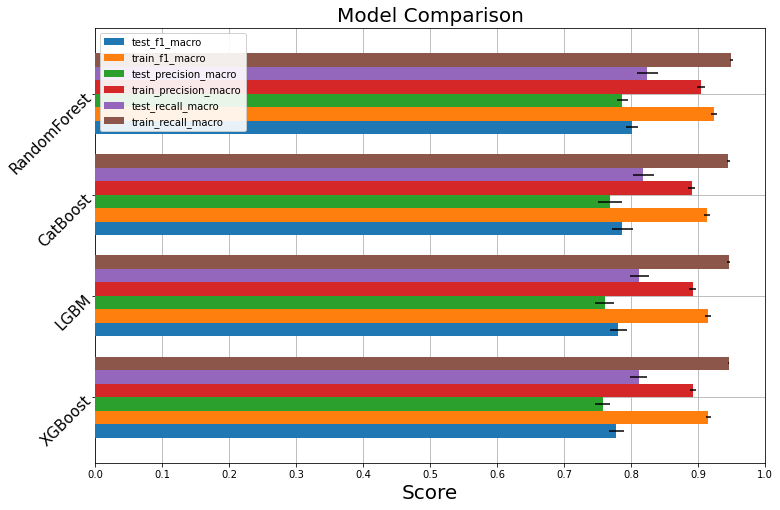

In [14]:
# Overview of model comparision
metrics_df = hyperparameterstuning.compare_models(metrics, output_folder=output_path)

#mlflow.active_run()
#mlflow.log_artifact(output_path+'model_comparison.png',"metrics_comparision")

CatBoost_bestpipeline_fitted_model


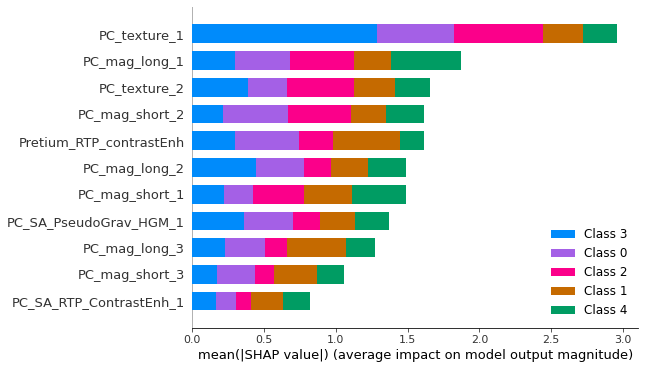

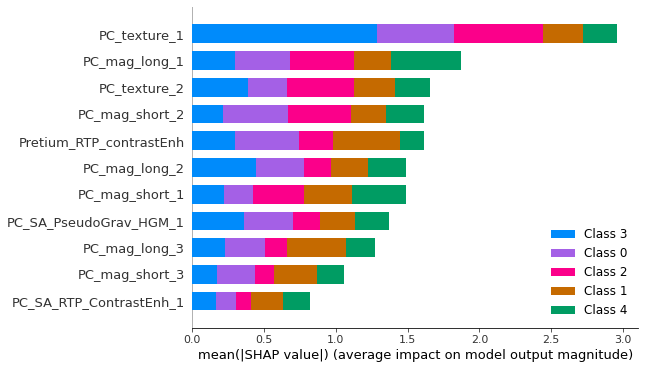

LGBM_bestpipeline_fitted_model


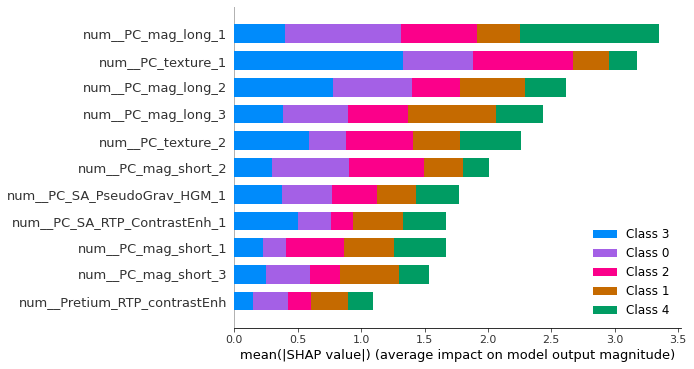

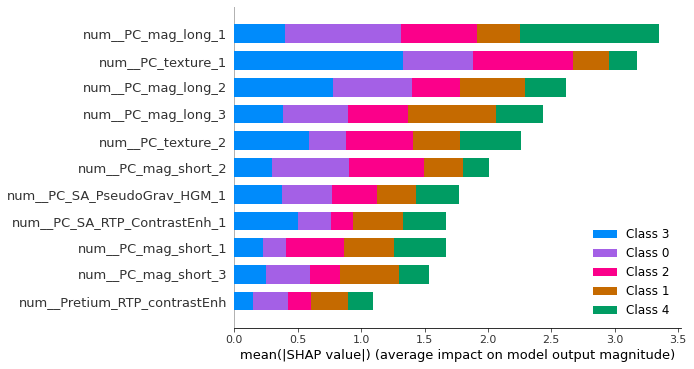

RandomForest_bestpipeline_fitted_model


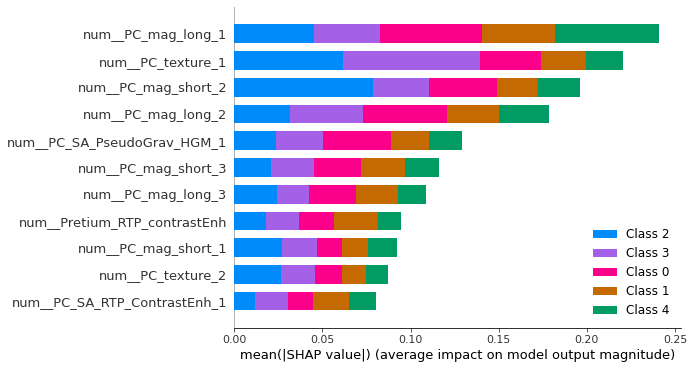

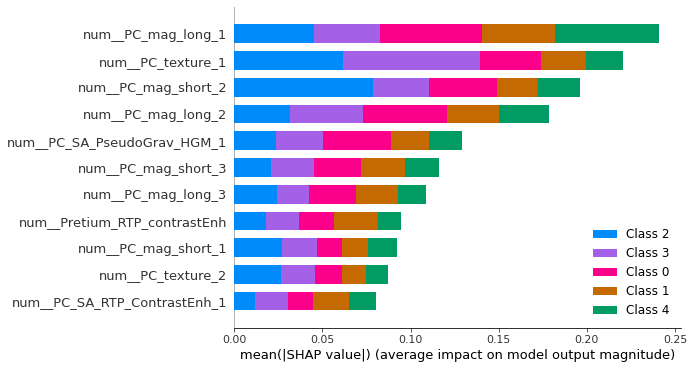

XGBoost_bestpipeline_fitted_model


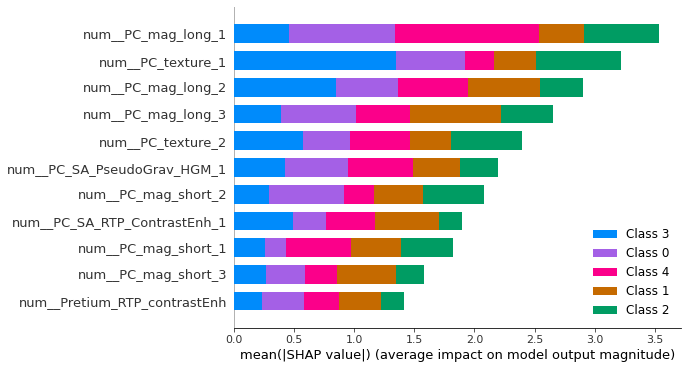

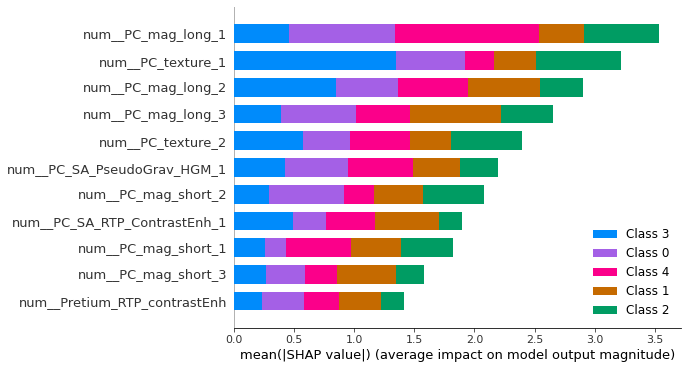

<Figure size 864x864 with 0 Axes>

In [16]:
# shapely values on hold out dataset
from GeoDS.prospectivity import featureimportance
#import hyperparameterstuning
from importlib import reload
#reload(hyperparameterstuning)
models = hyperparameterstuning.loadJobsFromFolder(output_path+'models/')
for i in models:    
    print(i)
    featureimportance.plot_shap_values(models[i], X_test, combine_cat_class_importances=False)

CatBoost_bestpipeline_fitted_model


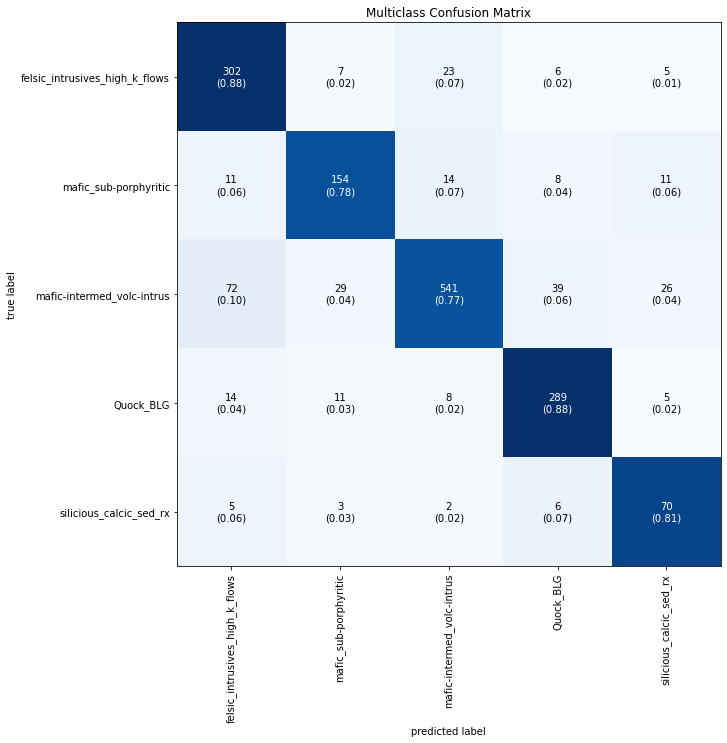

LGBM_bestpipeline_fitted_model


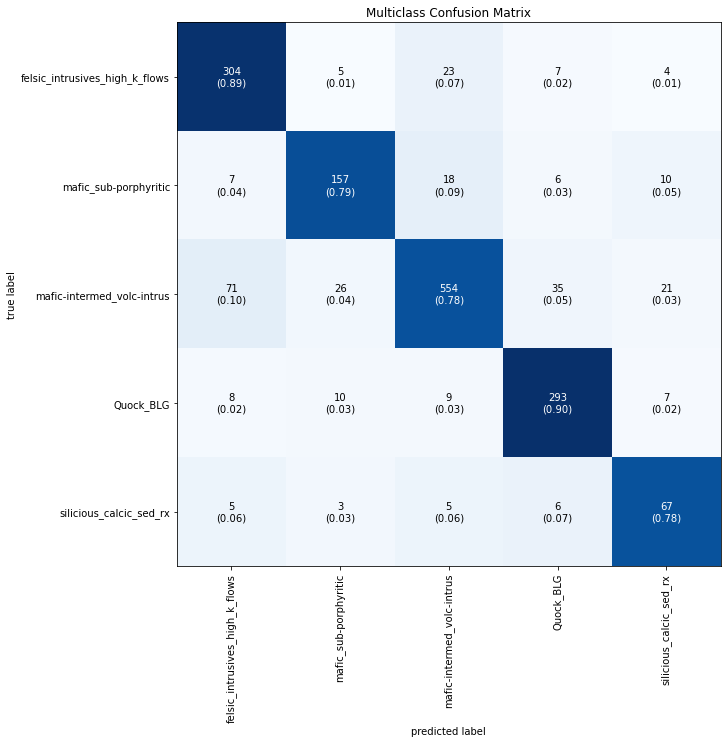

RandomForest_bestpipeline_fitted_model


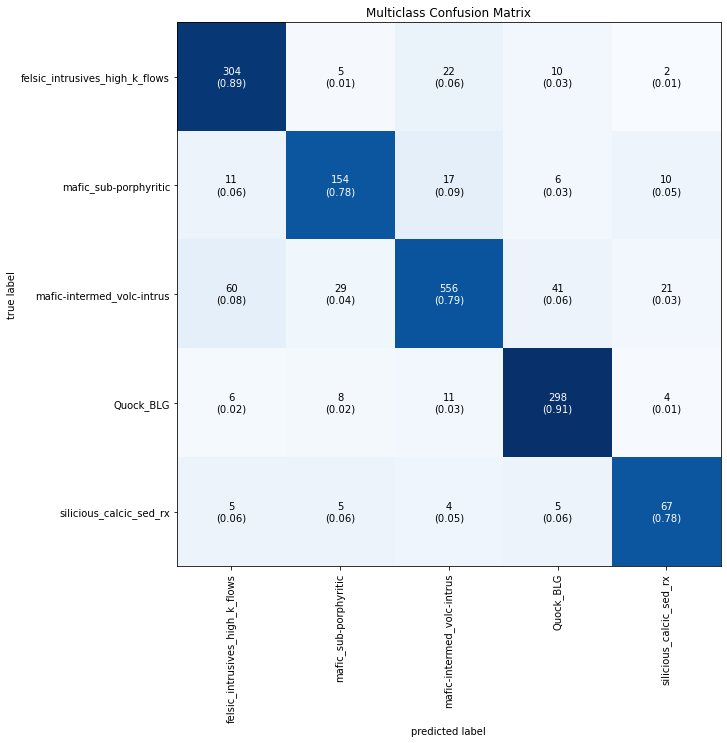

XGBoost_bestpipeline_fitted_model


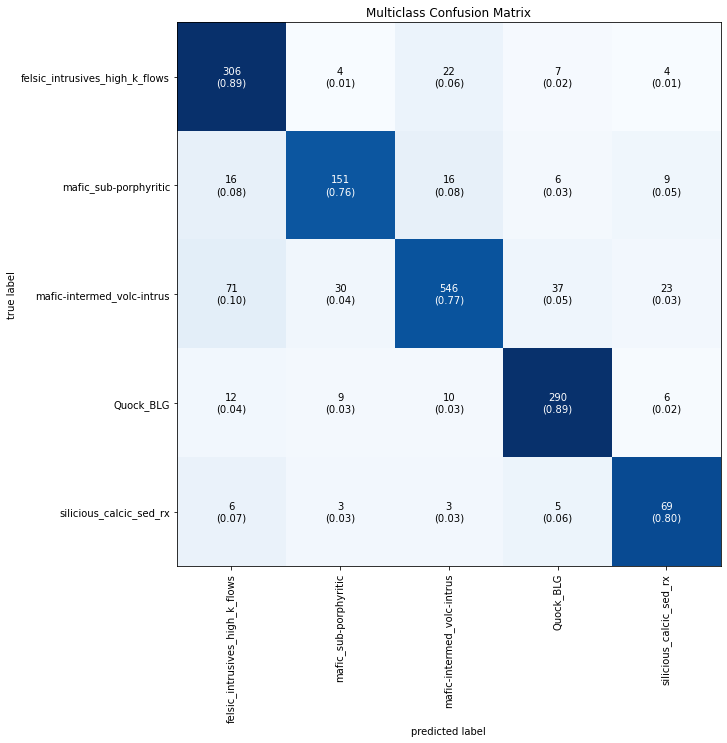

In [18]:

actual_classes = y_test.unique().tolist()
actual_classes.sort()
actual_classes = [x+1 for x in actual_classes]

def replace_classes(actual_classes, correspondance_dict):
    original_classes = [correspondance_dict[code] for code in actual_classes]
    return original_classes

classes = replace_classes(actual_classes, correspondance_dict)
models = hyperparameterstuning.loadJobsFromFolder(output_path+'models/')

test_df = pd.DataFrame({"y_test":y_test})
for i in models:
    print(i)
    preds = models[i].predict_proba(X_test)
    preds_max = np.argmax(preds,axis=1)
    test_df[i] = preds_max
    df_cr = reporting.multiclass_confusion_matrix_plot(y_test, preds_max, classes, output_path)
    #mlflow.active_run()
    #mlflow.log_artifact(output_path+'multiclass_confusion_matrix.png',"metrics_comparision")
    

In [137]:
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score
mlflow.active_run()
for i in test_df.columns:
    mlflow.log_metric("accuracy_{0}".format(i),accuracy_score(y_test,test_df[i]))
    mlflow.log_metric("f1_score_{0}".format(i),f1_score(y_test,test_df[i], average = 'macro'))
    mlflow.log_metric("precision_{0}".format(i),precision_score(y_test,test_df[i], average = 'macro'))
    mlflow.log_metric("recall_{0}".format(i),recall_score(y_test,test_df[i], average = 'macro'))
    

# Final Prediction

In [20]:
predictions = cube.subset(['coordinates'])

In [21]:
predictions

,x,y
1946,444475.0,6227975.0
1947,444525.0,6227975.0
1948,444575.0,6227975.0
1949,444625.0,6227975.0
1950,444675.0,6227975.0
...,...,...
362339,447325.0,6269625.0
362340,447375.0,6269625.0
362341,447425.0,6269625.0
362342,447475.0,6269625.0


In [23]:
num_class = len(np.unique(y))
for i in models:
    preds = models[i].predict_proba(all_X)
    predictions[i+"_prediction"] = np.argmax(preds,axis=1)
    predictions[i+"_entropy"] = entropy(preds, axis = 1)/np.log(num_class)

In [24]:
predictions.columns

Index(['x', 'y', 'CatBoost_bestpipeline_fitted_model_prediction',
       'CatBoost_bestpipeline_fitted_model_entropy',
       'LGBM_bestpipeline_fitted_model_prediction',
       'LGBM_bestpipeline_fitted_model_entropy',
       'RandomForest_bestpipeline_fitted_model_prediction',
       'RandomForest_bestpipeline_fitted_model_entropy',
       'XGBoost_bestpipeline_fitted_model_prediction',
       'XGBoost_bestpipeline_fitted_model_entropy'],
      dtype='object')

In [27]:
write_columns = ['CatBoost_bestpipeline_fitted_model_prediction',
       'CatBoost_bestpipeline_fitted_model_entropy',
       'LGBM_bestpipeline_fitted_model_prediction',
       'LGBM_bestpipeline_fitted_model_entropy',
       'RandomForest_bestpipeline_fitted_model_prediction',
       'RandomForest_bestpipeline_fitted_model_entropy',
       'XGBoost_bestpipeline_fitted_model_prediction',
       'XGBoost_bestpipeline_fitted_model_entropy']

In [28]:
#utilities.csv_to_raster(input_csv = predictions, output_directory = output_path,
#                        columns = write_columns, categories = None, x_field='x', y_field='y',
#                        dstCRS =crs)

utilities.df_to_gtiffs(df = predictions, crs = crs, outfolder = output_path, x_col = 'x', y_col = 'y',
                           features = write_columns, nodata = -9999, verbose = True)

inferred resolution from coordinates is 50.0

8 geotiffs written.
./3_processing/3_tuning_model_outputs/CatBoost_bestpipeline_fitted_model_prediction.tif
./3_processing/3_tuning_model_outputs/CatBoost_bestpipeline_fitted_model_entropy.tif
./3_processing/3_tuning_model_outputs/LGBM_bestpipeline_fitted_model_prediction.tif
./3_processing/3_tuning_model_outputs/LGBM_bestpipeline_fitted_model_entropy.tif
./3_processing/3_tuning_model_outputs/RandomForest_bestpipeline_fitted_model_prediction.tif
./3_processing/3_tuning_model_outputs/RandomForest_bestpipeline_fitted_model_entropy.tif
./3_processing/3_tuning_model_outputs/XGBoost_bestpipeline_fitted_model_prediction.tif
./3_processing/3_tuning_model_outputs/XGBoost_bestpipeline_fitted_model_entropy.tif


['./3_processing/3_tuning_model_outputs/CatBoost_bestpipeline_fitted_model_prediction.tif',
 './3_processing/3_tuning_model_outputs/CatBoost_bestpipeline_fitted_model_entropy.tif',
 './3_processing/3_tuning_model_outputs/LGBM_bestpipeline_fitted_model_prediction.tif',
 './3_processing/3_tuning_model_outputs/LGBM_bestpipeline_fitted_model_entropy.tif',
 './3_processing/3_tuning_model_outputs/RandomForest_bestpipeline_fitted_model_prediction.tif',
 './3_processing/3_tuning_model_outputs/RandomForest_bestpipeline_fitted_model_entropy.tif',
 './3_processing/3_tuning_model_outputs/XGBoost_bestpipeline_fitted_model_prediction.tif',
 './3_processing/3_tuning_model_outputs/XGBoost_bestpipeline_fitted_model_entropy.tif']

In [142]:
mlflow.end_run()

# Majority (stacking) classifier

In [34]:
from scipy import stats

In [35]:
predict_columns = ['CatBoost_bestpipeline_fitted_model_prediction',
       'LGBM_bestpipeline_fitted_model_prediction',
       'RandomForest_bestpipeline_fitted_model_prediction',
       'XGBoost_bestpipeline_fitted_model_prediction']

In [36]:
stacking_arrays = predictions[predict_columns].values

In [37]:
m = stats.mode(stacking_arrays, axis = 1)
mode_values = m[0]
mode_counts = m[1]

In [38]:
predictions['Stacking_classifier_MODE'] = mode_values.reshape(-1)
predictions['Stacking_classifier_COUNTS'] = mode_counts.reshape(-1)/len(predict_columns)

In [40]:
stacking_columns = ['Stacking_classifier_MODE', 'Stacking_classifier_COUNTS']

In [41]:
utilities.df_to_gtiffs(df = predictions, crs = crs, outfolder = output_path, x_col = 'x', y_col = 'y',
                           features = stacking_columns, nodata = -9999, verbose = True)

inferred resolution from coordinates is 50.0

2 geotiffs written.
./3_processing/3_tuning_model_outputs/Stacking_classifier_MODE.tif
./3_processing/3_tuning_model_outputs/Stacking_classifier_COUNTS.tif


['./3_processing/3_tuning_model_outputs/Stacking_classifier_MODE.tif',
 './3_processing/3_tuning_model_outputs/Stacking_classifier_COUNTS.tif']